In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import zipfile
import os
from pathlib import Path
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVC

import tensorflow as tf
from tensorflow import keras

import gdown

In [6]:
# Téléchargement du csv contenant les types et les noms des pokémons
url_csv = 'https://drive.google.com/uc?id=1Fb2EYHSBG5HMxTPdRanCf5AJ_xdROQNQ'
output_csv = 'dataset.csv'
gdown.download(url_csv, output_csv, quiet=False)

# Téléchargemetn des images
url_zip = 'https://drive.google.com/uc?id=17UgFd4modnT7ukWzW9kXd4zmaBbkN_tD'
output_zip = 'sprites2.zip'
gdown.download(url_zip, output_zip, quiet=False)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")


# Telecharger fusion
url_csv = 'https://drive.google.com/uc?id=1nSHF-_6BE-Pejs07kPVJ5cLz6fMtIv1Z'
output_csv = 'fusions.csv'
gdown.download(url_csv, output_csv, quiet=False)

# Telecharger CSV
url_zip = 'https://drive.google.com/uc?id=1osHUbIcQhdOeq6b2Gxhi4xzM0wJikK-A'
output_zip = 'spritesFusion.zip'
gdown.download(url_zip, output_zip, quiet=False)



with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")  # Décompresse dans le répertoire courant


Downloading...
From: https://drive.google.com/uc?id=1Fb2EYHSBG5HMxTPdRanCf5AJ_xdROQNQ
To: c:\Users\mathi\Documents\ProjetIA\dataset.csv
100%|██████████| 44.0k/44.0k [00:00<00:00, 2.22MB/s]
Downloading...
From: https://drive.google.com/uc?id=17UgFd4modnT7ukWzW9kXd4zmaBbkN_tD
To: c:\Users\mathi\Documents\ProjetIA\sprites2.zip
100%|██████████| 1.52M/1.52M [00:00<00:00, 8.73MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nSHF-_6BE-Pejs07kPVJ5cLz6fMtIv1Z
To: c:\Users\mathi\Documents\ProjetIA\fusions.csv
100%|██████████| 5.45M/5.45M [00:00<00:00, 22.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1osHUbIcQhdOeq6b2Gxhi4xzM0wJikK-A
From (redirected): https://drive.google.com/uc?id=1osHUbIcQhdOeq6b2Gxhi4xzM0wJikK-A&confirm=t&uuid=5994f550-e1f4-4982-a085-e021980e4121
To: c:\Users\mathi\Documents\ProjetIA\spritesFusion.zip
100%|██████████| 491M/491M [01:35<00:00, 5.12MB/s]


In [6]:
# create a path to the pokemon image directory
train_dir = 'sprites/'

train_path = Path(train_dir)

# create a dataframe with the name and filepath of each pokemon
files = list(train_path.glob('*.png'))
names = [os.path.split(x)[1] for x in list(train_path.glob('*.png'))]
image_df = pd.concat([pd.Series(names, name='Name'), pd.Series(files, name='Filepath').astype(str)], axis=1)
image_df['Name'] = image_df['Name'].apply(lambda x: re.sub(r'\.\w+$', '', x)).str.lower()

# load in csv with the name, primary type, and secondary type of each pokemon
label_df = pd.read_csv('dataset.csv')
label_df['Name'] = label_df['Name'].str.lower()

# merge image_df with label_df
df = image_df.merge(label_df, on='Name')

# TODO:Ajouter le pokemons 2 fois s'il a deux types :
# Dupliquer les lignes où 'Type 2' n'est pas nul
df_type2 = df[df['Type 2'].notna()].copy()

# Remplacer 'Type 1' par 'Type 2' dans les lignes dupliquées
df_type2['Type 1'] = df_type2['Type 2']

# Concaténer le dataframe original avec les lignes dupliquées
df = pd.concat([df, df_type2])

# Supprimer les colonnes inutiles et renommer les colonnes restantes
df = df.drop(['Type 2', 'Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation', 'Legendary'], axis=1) 
df.columns = ['Name', 'Filepath', 'no', 'Type1']

df.head()

,Name,Filepath,no,Type1
0,abomasnow,sprites\abomasnow.png,460,Grass
1,abra,sprites\abra.png,63,Psychic
2,absol,sprites\absol.png,359,Dark
3,accelgor,sprites\accelgor.png,617,Bug
4,aerodactyl,sprites\aerodactyl.png,142,Rock


In [7]:
# limit data to Fire and Water types
types = df['Type1'].unique()
comboTypes = [(type1, type2) for type1 in types for type2 in types if type1 != type2]
print(len(comboTypes))
#get unique combinations of types and symetric combinations
for i in range(len(comboTypes)):
  comboTypes[i] = tuple(sorted(comboTypes[i]))
comboTypes = list(set(comboTypes))
print(len(comboTypes))
print(comboTypes)

models = {f"{type1}_{type2}" : {"model" : None,"dataset": {},'train_set':None,'test_set':None, "accuracy_score":0, "f1_score": 0,"Recall": 0 } for (type1,type2) in comboTypes}
print(models)
for combo in comboTypes:
    type1, type2 = combo
    print(f"Training model for {type1} and {type2} types")
    comboStr = f"{type1}_{type2}"
    # limit data to Fire and Water types
    df_combo = df[(df['Type1'] == type1) | (df['Type1'] == type2)]
    # create a dictionary to hold the data for each type
    models[comboStr]['dataset'] = df_combo
    

306
153
[('Ice', 'Steel'), ('Fairy', 'Ice'), ('Dark', 'Grass'), ('Fighting', 'Flying'), ('Grass', 'Psychic'), ('Ground', 'Water'), ('Electric', 'Flying'), ('Grass', 'Rock'), ('Bug', 'Electric'), ('Bug', 'Flying'), ('Flying', 'Ghost'), ('Dragon', 'Fighting'), ('Fighting', 'Grass'), ('Dragon', 'Electric'), ('Dragon', 'Flying'), ('Electric', 'Grass'), ('Flying', 'Ground'), ('Ghost', 'Grass'), ('Fighting', 'Ground'), ('Ground', 'Poison'), ('Electric', 'Ground'), ('Ghost', 'Ground'), ('Rock', 'Water'), ('Fire', 'Psychic'), ('Bug', 'Ghost'), ('Poison', 'Psychic'), ('Bug', 'Ground'), ('Dragon', 'Ghost'), ('Fire', 'Rock'), ('Fairy', 'Psychic'), ('Poison', 'Rock'), ('Dragon', 'Normal'), ('Fire', 'Steel'), ('Grass', 'Water'), ('Ground', 'Steel'), ('Fairy', 'Rock'), ('Fairy', 'Steel'), ('Dark', 'Electric'), ('Dark', 'Flying'), ('Flying', 'Ice'), ('Grass', 'Poison'), ('Bug', 'Fire'), ('Rock', 'Steel'), ('Fire', 'Water'), ('Poison', 'Water'), ('Ghost', 'Ice'), ('Dark', 'Ghost'), ('Dragon', 'Fire'),

In [8]:

for combo in comboTypes:
    type1, type2 = combo
    comboStr = f"{type1}_{type2}"
    # load in the data for the current type
    df_combo = models[comboStr]['dataset']
    # split the data into training and testing sets
    print(f'Generating train and test sets for {type1} and {type2} types')
    X_train, X_test, y_train, y_test = train_test_split(df_combo['Filepath'], df_combo['Type1'], test_size=0.2, random_state=42)
    models[comboStr]['train_set'] = (X_train, y_train)
    models[comboStr]['test_set'] = (X_test, y_test)
    

Generating train and test sets for Ice and Steel types
Generating train and test sets for Fairy and Ice types
Generating train and test sets for Dark and Grass types
Generating train and test sets for Fighting and Flying types
Generating train and test sets for Grass and Psychic types
Generating train and test sets for Ground and Water types
Generating train and test sets for Electric and Flying types
Generating train and test sets for Grass and Rock types
Generating train and test sets for Bug and Electric types
Generating train and test sets for Bug and Flying types
Generating train and test sets for Flying and Ghost types
Generating train and test sets for Dragon and Fighting types
Generating train and test sets for Fighting and Grass types
Generating train and test sets for Dragon and Electric types
Generating train and test sets for Dragon and Flying types
Generating train and test sets for Electric and Grass types
Generating train and test sets for Flying and Ground types
Generat

In [9]:
import math
def show_images(filepaths):
    total_images = len(filepaths)
    num_rows = math.ceil(total_images / 3)  # we keep 3 columns and adjust the number of rows
    plt.figure(figsize=(10, num_rows * 3.3))  # adjust the figure height based on the number of rows
    count = 0
    for filepath in filepaths:
        try:
            image = mpimg.imread(filepath)
            plt.subplot(num_rows, 3, count + 1)
            plt.imshow(image)
            plt.axis('off')
            count += 1
        except:
            pass
    plt.show()

def load_and_preprocess_image(filepath):
        image = tf.io.read_file(filepath)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, [128, 128])
        image /= 255.0
        image = image.numpy().flatten()  # flatten the image and reassign the result to image
        return image

def training(model, x_train, y_train, x_test, y_test):
    # load and preprocess the images
    x_train = np.array([load_and_preprocess_image(filepath) for filepath in x_train])
    x_test = np.array([load_and_preprocess_image(filepath) for filepath in x_test])

    
    model.fit(x_train, y_train)

    # make predictions
    y_pred = model.predict(x_test)

    # calculate the accèuracy of the model
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')

    # calculate the f1 score of the model
    f1 = sklearn.metrics.f1_score(y_test, y_pred)
    print(f'F1 Score: {f1}')

    # calculate the recall of the model
    recall = sklearn.metrics.recall_score(y_test, y_pred)
    print(f'Recall: {recall}')
    return model, accuracy, f1, recall

In [26]:
#Regression Logistique

for combo in comboTypes:
    type1, type2 = combo
    comboStr = f"{type1}_{type2}"
    print(f"Training model for {type1} and {type2} types")
    # load in the data for the current type
    X_train, y_train = models[comboStr]['train_set']
    X_test, y_test = models[comboStr]['test_set']
    y_train= [0 if y==type1 else 1 for y in y_train]
    y_test= [0 if y==type1 else 1 for y in y_test]
    # create a linear regression model
    model = LogisticRegression(max_iter=1000) # changer ca pour tester d'autres modeles
    # train the model
    models[comboStr]['model'], models[comboStr]['accuracy_score'], models[comboStr]['f1_score'], models[comboStr]['Recall'] = training(model, X_train, y_train, X_test, y_test)

Training model for Ice and Steel types
Accuracy: 0.8
F1 Score: 0.8421052631578947
Recall: 0.8888888888888888
Training model for Fairy and Ice types
Accuracy: 0.38461538461538464
F1 Score: 0.3333333333333333
Recall: 0.4
Training model for Dark and Grass types
Accuracy: 0.68
F1 Score: 0.7777777777777778
Recall: 0.7777777777777778
Training model for Fighting and Flying types
Accuracy: 0.7692307692307693
F1 Score: 0.85
Recall: 0.8947368421052632
Training model for Grass and Psychic types
Accuracy: 0.6333333333333333
F1 Score: 0.47619047619047616
Recall: 0.5
Training model for Ground and Water types
Accuracy: 0.4857142857142857
F1 Score: 0.625
Recall: 0.5769230769230769
Training model for Electric and Flying types
Accuracy: 0.6538461538461539
F1 Score: 0.7692307692307693
Recall: 0.8823529411764706
Training model for Grass and Rock types
Accuracy: 0.7037037037037037
F1 Score: 0.6
Recall: 0.5
Training model for Bug and Electric types
Accuracy: 0.45454545454545453
F1 Score: 0.3333333333333333


In [35]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np

def CNNModel():
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')  # Utilisez 'sigmoid' pour la classification binaire
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall'])
    return model

def load_and_preprocess_image(image_path, target_size=(128, 128)):
    """Charge une image, la redimensionne et la convertit en un tableau."""
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)  # Ajoute une dimension pour le batch size
    return image

def prepare_dataset(image_paths, labels, target_size=(128, 128)):
    """Prépare les ensembles de données d'images et d'étiquettes."""
    images = np.vstack([load_and_preprocess_image(path, target_size) for path in image_paths])
    labels = np.array(labels)
    return images, labels

# Initialiser des listes pour stocker les scores d'accuracy et de recall
accuracy_scores = []
recall_scores = []

# Assurez-vous que comboTypes et models sont bien définis avant de lancer cette partie du code
for combo in comboTypes:
    type1, type2 = combo
    comboStr = f"{type1}_{type2}"
    print(f"Training model for {type1} and {type2} types")
    
    # Charger et préparer les données pour le type de combinaison actuel
    X_train_paths, y_train = models[comboStr]['train_set']
    X_test_paths, y_test = models[comboStr]['test_set']
    y_train = [0 if y == type1 else 1 for y in y_train]
    y_test = [0 if y == type1 else 1 for y in y_test]
    
    X_train, y_train = prepare_dataset(X_train_paths, y_train)
    X_test, y_test = prepare_dataset(X_test_paths, y_test)
    
    # Créer et entraîner le modèle CNN
    model = CNNModel()
    model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test))
    
    # Évaluation du modèle
    scores = model.evaluate(X_test, y_test, verbose=0)
    accuracy = scores[1]
    recall = scores[2]
    print(f"Accuracy: {accuracy*100}%")
    print(f"Recall: {recall*100}%")

    # Ajouter les scores à la liste
    accuracy_scores.append(accuracy)
    recall_scores.append(recall)

    y_pred = model.predict(X_test)
    y_pred_rounded = np.round(y_pred).astype(int)
    f1 = f1_score(y_test, y_pred_rounded)
    print(f"F1 Score: {f1}")
    
    # Enregistrement du modèle et des scores
    models[comboStr]['model'] = model
    models[comboStr]['accuracy_score'] = accuracy
    # Ajouter d'autres métriques au besoin

# Calculer les moyennes d'accuracy et de recall
accuracy_mean = np.mean(accuracy_scores)
recall_mean = np.mean(recall_scores)

print(f"\nMean Accuracy: {accuracy_mean*100}%")
print(f"Mean Recall: {recall_mean*100}%")


Training model for Ice and Steel types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.4874 - loss: 203.6406 - recall: 0.6559 - val_accuracy: 0.4000 - val_loss: 209.6357 - val_recall: 0.0000e+00
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4896 - loss: 136.5336 - recall: 0.0430 - val_accuracy: 0.6000 - val_loss: 40.8852 - val_recall: 1.0000
Accuracy: 60.00000238418579%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
F1 Score: 0.75
Training model for Fairy and Ice types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - accuracy: 0.5617 - loss: 89.9546 - recall: 0.5397 - val_accuracy: 0.3846 - val_loss: 306.8106 - val_recall: 1.0000
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5489 - loss: 99.6243 - recall: 0.9048 - val_accuracy: 0.6154 - val_loss: 48.4130 - val_recall: 0.0000e+00
Accuracy: 61.538463830947876%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
F1 Score: 0.0
Training model for Dark and Grass types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.6200 - loss: 57.2890 - recall: 0.5726 - val_accuracy: 0.7200 - val_loss: 17.6904 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6453 - loss: 17.4630 - recall: 1.0000 - val_accuracy: 0.7200 - val_loss: 3.0573 - val_recall: 1.0000
Accuracy: 72.00000286102295%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
F1 Score: 0.8372093023255814
Training model for Fighting and Flying types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.6253 - loss: 98.7309 - recall: 0.7400 - val_accuracy: 0.3846 - val_loss: 34.3027 - val_recall: 0.2105
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3865 - loss: 17.4760 - recall: 0.1448 - val_accuracy: 0.5000 - val_loss: 3.8049 - val_recall: 0.4211
Accuracy: 50.0%
Recall: 42.105263471603394%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
F1 Score: 0.5517241379310345
Training model for Grass and Psychic types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5076 - loss: 88.4719 - recall: 0.4799 - val_accuracy: 0.5333 - val_loss: 4.0037 - val_recall: 0.3000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5628 - loss: 4.6052 - recall: 0.8414 - val_accuracy: 0.3333 - val_loss: 4.5223 - val_recall: 1.0000
Accuracy: 33.33333432674408%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
F1 Score: 0.5
Training model for Ground and Water types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.5212 - loss: 83.4078 - recall: 0.5930 - val_accuracy: 0.5429 - val_loss: 9.7322 - val_recall: 0.6923
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5098 - loss: 7.9919 - recall: 0.4447 - val_accuracy: 0.3143 - val_loss: 2.9468 - val_recall: 0.0769
Accuracy: 31.42857253551483%
Recall: 7.6923079788684845%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
F1 Score: 0.14285714285714285
Training model for Electric and Flying types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.5201 - loss: 74.2083 - recall: 0.5390 - val_accuracy: 0.6538 - val_loss: 39.5632 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6447 - loss: 15.1720 - recall: 0.8703 - val_accuracy: 0.3462 - val_loss: 10.0108 - val_recall: 0.0000e+00
Accuracy: 34.61538553237915%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
F1 Score: 0.0
Training model for Grass and Rock types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.5448 - loss: 68.5882 - recall: 0.3747 - val_accuracy: 0.4444 - val_loss: 29.5286 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4157 - loss: 18.9128 - recall: 1.0000 - val_accuracy: 0.6296 - val_loss: 4.3531 - val_recall: 0.3333
Accuracy: 62.962961196899414%
Recall: 33.33333432674408%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
F1 Score: 0.4444444444444444
Training model for Bug and Electric types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.4036 - loss: 29.0389 - recall: 0.2442 - val_accuracy: 0.6818 - val_loss: 5.4023 - val_recall: 0.6000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7636 - loss: 4.2634 - recall: 0.5492 - val_accuracy: 0.3182 - val_loss: 20.6464 - val_recall: 0.3000
Accuracy: 31.81818127632141%
Recall: 30.000001192092896%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
F1 Score: 0.2857142857142857
Training model for Bug and Flying types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5348 - loss: 86.0680 - recall: 0.5466 - val_accuracy: 0.5484 - val_loss: 16.1213 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5675 - loss: 12.7101 - recall: 0.6503 - val_accuracy: 0.5161 - val_loss: 5.2559 - val_recall: 0.1176
Accuracy: 51.61290168762207%
Recall: 11.764705926179886%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
F1 Score: 0.21052631578947367
Training model for Flying and Ghost types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.4558 - loss: 105.0851 - recall: 0.3620 - val_accuracy: 0.6667 - val_loss: 7.9978 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7515 - loss: 11.3141 - recall: 0.0000e+00 - val_accuracy: 0.6667 - val_loss: 10.0766 - val_recall: 0.0000e+00
Accuracy: 66.66666865348816%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
F1 Score: 0.0
Training model for Dragon and Fighting types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.5789 - loss: 98.4726 - recall: 0.7172 - val_accuracy: 0.3750 - val_loss: 153.4083 - val_recall: 0.0000e+00
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4633 - loss: 102.7915 - recall: 0.0202 - val_accuracy: 0.6875 - val_loss: 5.4001 - val_recall: 1.0000
Accuracy: 68.75%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
F1 Score: 0.8
Training model for Fighting and Grass types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.4622 - loss: 91.7318 - recall: 0.4529 - val_accuracy: 0.4800 - val_loss: 7.1750 - val_recall: 0.8571
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7182 - loss: 4.5372 - recall: 0.9864 - val_accuracy: 0.5600 - val_loss: 6.0626 - val_recall: 1.0000
Accuracy: 56.00000023841858%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
F1 Score: 0.717948717948718
Training model for Dragon and Electric types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - accuracy: 0.4518 - loss: 46.6136 - recall: 0.4234 - val_accuracy: 0.3750 - val_loss: 128.0194 - val_recall: 0.0000e+00
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5487 - loss: 38.9014 - recall: 0.2782 - val_accuracy: 0.6250 - val_loss: 18.5012 - val_recall: 1.0000
Accuracy: 62.5%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
F1 Score: 0.7692307692307693
Training model for Dragon and Flying types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.5631 - loss: 120.6531 - recall: 0.5645 - val_accuracy: 0.7200 - val_loss: 49.1633 - val_recall: 0.9474
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6297 - loss: 13.9754 - recall: 0.7811 - val_accuracy: 0.2400 - val_loss: 23.0659 - val_recall: 0.0526
Accuracy: 23.999999463558197%
Recall: 5.263157933950424%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
F1 Score: 0.09523809523809523
Training model for Electric and Grass types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.4974 - loss: 45.6705 - recall: 0.5949 - val_accuracy: 0.6800 - val_loss: 57.7482 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7747 - loss: 16.1643 - recall: 0.8967 - val_accuracy: 0.3200 - val_loss: 18.7584 - val_recall: 0.1176
Accuracy: 31.999999284744263%
Recall: 11.764705926179886%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
F1 Score: 0.19047619047619047
Training model for Flying and Ground types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5469 - loss: 41.6056 - recall: 0.4220 - val_accuracy: 0.4138 - val_loss: 16.4017 - val_recall: 0.4167
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5949 - loss: 14.3554 - recall: 0.4215 - val_accuracy: 0.5862 - val_loss: 12.1118 - val_recall: 0.0000e+00
Accuracy: 58.62069129943848%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
F1 Score: 0.0
Training model for Ghost and Grass types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.5955 - loss: 22.3543 - recall: 0.7175 - val_accuracy: 0.3636 - val_loss: 151.7769 - val_recall: 0.1250
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6012 - loss: 13.5029 - recall: 0.4760 - val_accuracy: 0.5455 - val_loss: 34.8404 - val_recall: 0.6875
Accuracy: 54.54545617103577%
Recall: 68.75%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
F1 Score: 0.6875
Training model for Fighting and Ground types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.5078 - loss: 30.8525 - recall: 0.4680 - val_accuracy: 0.6190 - val_loss: 26.9384 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5508 - loss: 30.4986 - recall: 1.0000 - val_accuracy: 0.6190 - val_loss: 12.7383 - val_recall: 1.0000
Accuracy: 61.90476417541504%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
F1 Score: 0.7647058823529411
Training model for Ground and Poison types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.5623 - loss: 60.5495 - recall: 0.4896 - val_accuracy: 0.4783 - val_loss: 41.2326 - val_recall: 0.1667
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5039 - loss: 23.0108 - recall: 0.1667 - val_accuracy: 0.6087 - val_loss: 16.2869 - val_recall: 0.2500
Accuracy: 60.86956262588501%
Recall: 25.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
F1 Score: 0.4
Training model for Electric and Ground types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.4539 - loss: 113.6723 - recall: 0.4619 - val_accuracy: 0.5500 - val_loss: 136.6662 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6187 - loss: 49.8258 - recall: 0.9086 - val_accuracy: 0.4000 - val_loss: 17.7150 - val_recall: 0.0000e+00
Accuracy: 40.00000059604645%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
F1 Score: 0.0
Training model for Ghost and Ground types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.5539 - loss: 43.4896 - recall: 0.6840 - val_accuracy: 0.5000 - val_loss: 134.6977 - val_recall: 0.5000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5566 - loss: 25.0666 - recall: 0.5235 - val_accuracy: 0.6111 - val_loss: 41.1574 - val_recall: 0.5000
Accuracy: 61.11111044883728%
Recall: 50.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
F1 Score: 0.5882352941176471
Training model for Rock and Water types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.4364 - loss: 114.7084 - recall: 0.4261 - val_accuracy: 0.6000 - val_loss: 9.2473 - val_recall: 1.0000
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7110 - loss: 9.6933 - recall: 1.0000 - val_accuracy: 0.6000 - val_loss: 4.2412 - val_recall: 1.0000
Accuracy: 60.00000238418579%
Recall: 100.0%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
F1 Score: 0.75
Training model for Fire and Psychic types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.5209 - loss: 36.8522 - recall: 0.5263 - val_accuracy: 0.6000 - val_loss: 30.5310 - val_recall: 0.5714
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5785 - loss: 22.6998 - recall: 0.5434 - val_accuracy: 0.5600 - val_loss: 20.0737 - val_recall: 0.5000
Accuracy: 56.00000023841858%
Recall: 50.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
F1 Score: 0.56
Training model for Bug and Ghost types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.6493 - loss: 78.1930 - recall: 0.4083 - val_accuracy: 0.4737 - val_loss: 9.1482 - val_recall: 0.3333
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6071 - loss: 9.1759 - recall: 0.9160 - val_accuracy: 0.6842 - val_loss: 6.6739 - val_recall: 0.1667
Accuracy: 68.42105388641357%
Recall: 16.66666716337204%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
F1 Score: 0.25
Training model for Poison and Psychic types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.5311 - loss: 153.7570 - recall: 0.4936 - val_accuracy: 0.5200 - val_loss: 22.0015 - val_recall: 0.9231
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6100 - loss: 17.8181 - recall: 1.0000 - val_accuracy: 0.5200 - val_loss: 9.7903 - val_recall: 1.0000
Accuracy: 51.99999809265137%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
F1 Score: 0.6842105263157895
Training model for Bug and Ground types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.5838 - loss: 64.9321 - recall: 0.6857 - val_accuracy: 0.7200 - val_loss: 23.1709 - val_recall: 0.0000e+00
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4605 - loss: 55.2656 - recall: 0.0078 - val_accuracy: 0.6000 - val_loss: 4.7624 - val_recall: 0.0000e+00
Accuracy: 60.00000238418579%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
F1 Score: 0.0
Training model for Dragon and Ghost types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 746ms/step - accuracy: 0.6290 - loss: 102.3422 - recall: 0.3333 - val_accuracy: 0.5714 - val_loss: 86.2291 - val_recall: 1.0000
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5409 - loss: 67.8474 - recall: 0.9475 - val_accuracy: 0.4286 - val_loss: 37.3686 - val_recall: 0.0000e+00
Accuracy: 42.85714328289032%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
F1 Score: 0.0
Training model for Fire and Rock types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 482ms/step - accuracy: 0.5518 - loss: 137.8728 - recall: 0.5917 - val_accuracy: 0.4545 - val_loss: 60.3477 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.5618 - loss: 35.0215 - recall: 0.2658 - val_accuracy: 0.5455 - val_loss: 29.6142 - val_recall: 1.0000
Accuracy: 54.54545617103577%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
F1 Score: 0.7058823529411765
Training model for Fairy and Psychic types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 497ms/step - accuracy: 0.3773 - loss: 129.2769 - recall: 0.4647 - val_accuracy: 0.4500 - val_loss: 7.7591 - val_recall: 0.4286
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.6234 - loss: 11.3069 - recall: 0.7862 - val_accuracy: 0.7000 - val_loss: 11.4149 - val_recall: 1.0000
Accuracy: 69.9999988079071%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
F1 Score: 0.8235294117647058
Training model for Poison and Rock types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 463ms/step - accuracy: 0.5487 - loss: 105.2125 - recall: 0.5627 - val_accuracy: 0.4783 - val_loss: 48.6079 - val_recall: 0.3077
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.5621 - loss: 22.7447 - recall: 0.2081 - val_accuracy: 0.4348 - val_loss: 33.1763 - val_recall: 0.0000e+00
Accuracy: 43.478259444236755%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
F1 Score: 0.0
Training model for Dragon and Normal types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 368ms/step - accuracy: 0.5089 - loss: 71.4720 - recall: 0.5389 - val_accuracy: 0.8889 - val_loss: 12.7514 - val_recall: 0.9048
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.6591 - loss: 22.5172 - recall: 0.6969 - val_accuracy: 0.3333 - val_loss: 6.8917 - val_recall: 0.1429
Accuracy: 33.33333432674408%
Recall: 14.28571492433548%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
F1 Score: 0.25
Training model for Fire and Steel types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 483ms/step - accuracy: 0.5234 - loss: 126.7213 - recall: 0.4219 - val_accuracy: 0.4211 - val_loss: 27.4415 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.4936 - loss: 16.8134 - recall: 0.5894 - val_accuracy: 0.5789 - val_loss: 15.6329 - val_recall: 0.0000e+00
Accuracy: 57.894736528396606%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
F1 Score: 0.0
Training model for Grass and Water types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 332ms/step - accuracy: 0.6007 - loss: 33.8904 - recall: 0.6462 - val_accuracy: 0.6750 - val_loss: 10.4946 - val_recall: 1.0000
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.6163 - loss: 10.4467 - recall: 0.9889 - val_accuracy: 0.6250 - val_loss: 3.8663 - val_recall: 0.5185
Accuracy: 62.5%
Recall: 51.851850748062134%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
F1 Score: 0.6511627906976745
Training model for Ground and Steel types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 475ms/step - accuracy: 0.5569 - loss: 68.7099 - recall: 0.4979 - val_accuracy: 0.7000 - val_loss: 3.3066 - val_recall: 0.5000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.5803 - loss: 14.3836 - recall: 0.8208 - val_accuracy: 0.3000 - val_loss: 9.1295 - val_recall: 1.0000
Accuracy: 30.000001192092896%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
F1 Score: 0.46153846153846156
Training model for Fairy and Rock types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 436ms/step - accuracy: 0.5075 - loss: 106.7190 - recall: 0.5352 - val_accuracy: 0.6667 - val_loss: 16.5888 - val_recall: 0.7333
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.5577 - loss: 17.7971 - recall: 0.5247 - val_accuracy: 0.1667 - val_loss: 19.5445 - val_recall: 0.0000e+00
Accuracy: 16.66666716337204%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
F1 Score: 0.0
Training model for Fairy and Steel types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 780ms/step - accuracy: 0.4265 - loss: 98.7084 - recall: 0.6084 - val_accuracy: 0.2667 - val_loss: 265.1716 - val_recall: 0.0000e+00
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.4408 - loss: 114.7143 - recall: 0.0000e+00 - val_accuracy: 0.8000 - val_loss: 4.0823 - val_recall: 0.7273
Accuracy: 80.0000011920929%
Recall: 72.72727489471436%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
F1 Score: 0.8421052631578947
Training model for Dark and Electric types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 472ms/step - accuracy: 0.5342 - loss: 102.1588 - recall: 0.6371 - val_accuracy: 0.5882 - val_loss: 38.9065 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.5225 - loss: 26.1165 - recall: 0.1870 - val_accuracy: 0.4118 - val_loss: 13.5136 - val_recall: 1.0000
Accuracy: 41.17647111415863%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
F1 Score: 0.5833333333333334
Training model for Dark and Flying types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - accuracy: 0.4522 - loss: 113.5666 - recall: 0.4494 - val_accuracy: 0.5385 - val_loss: 29.8162 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.6790 - loss: 15.2185 - recall: 1.0000 - val_accuracy: 0.5385 - val_loss: 13.6717 - val_recall: 1.0000
Accuracy: 53.84615659713745%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
F1 Score: 0.7
Training model for Flying and Ice types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 481ms/step - accuracy: 0.5592 - loss: 111.9725 - recall: 0.2661 - val_accuracy: 0.6250 - val_loss: 116.3424 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.6738 - loss: 32.0836 - recall: 0.1605 - val_accuracy: 0.5417 - val_loss: 7.7128 - val_recall: 0.7778
Accuracy: 54.16666865348816%
Recall: 77.77777910232544%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
F1 Score: 0.56
Training model for Grass and Poison types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 539ms/step - accuracy: 0.5150 - loss: 22.4800 - recall: 0.3937 - val_accuracy: 0.5000 - val_loss: 36.6748 - val_recall: 0.9231
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.5070 - loss: 14.2460 - recall: 0.9262 - val_accuracy: 0.5357 - val_loss: 4.0353 - val_recall: 0.6923
Accuracy: 53.57142686843872%
Recall: 69.2307710647583%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
F1 Score: 0.5806451612903226
Training model for Bug and Fire types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.5794 - loss: 95.6635 - recall: 0.5382 - val_accuracy: 0.4167 - val_loss: 42.8253 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5599 - loss: 27.9767 - recall: 0.5920 - val_accuracy: 0.6667 - val_loss: 20.4679 - val_recall: 0.0000e+00
Accuracy: 66.66666865348816%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
F1 Score: 0.0
Training model for Rock and Steel types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.4241 - loss: 43.2050 - recall: 0.4075 - val_accuracy: 0.6316 - val_loss: 17.2405 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5917 - loss: 18.9844 - recall: 0.1092 - val_accuracy: 0.5789 - val_loss: 5.7956 - val_recall: 0.8571
Accuracy: 57.894736528396606%
Recall: 85.71428656578064%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
F1 Score: 0.6
Training model for Fire and Water types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.5574 - loss: 52.3101 - recall: 0.6939 - val_accuracy: 0.3429 - val_loss: 11.7853 - val_recall: 0.0833
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4163 - loss: 7.3597 - recall: 0.1740 - val_accuracy: 0.6857 - val_loss: 1.9412 - val_recall: 1.0000
Accuracy: 68.57143044471741%
Recall: 100.0%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
F1 Score: 0.8135593220338984
Training model for Poison and Water types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.5459 - loss: 60.5723 - recall: 0.7084 - val_accuracy: 0.3429 - val_loss: 24.6622 - val_recall: 0.0435
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5074 - loss: 8.7270 - recall: 0.3665 - val_accuracy: 0.6571 - val_loss: 1.8012 - val_recall: 1.0000
Accuracy: 65.71428775787354%
Recall: 100.0%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
F1 Score: 0.7931034482758621
Training model for Ghost and Ice types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.4896 - loss: 52.8867 - recall: 0.6016 - val_accuracy: 0.6923 - val_loss: 28.2507 - val_recall: 0.6250
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5608 - loss: 78.8307 - recall: 0.5905 - val_accuracy: 0.6154 - val_loss: 25.8714 - val_recall: 1.0000
Accuracy: 61.538463830947876%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
F1 Score: 0.7619047619047619
Training model for Dark and Ghost types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.4622 - loss: 68.0918 - recall: 0.3485 - val_accuracy: 0.6000 - val_loss: 78.0489 - val_recall: 0.0000e+00
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6386 - loss: 54.1757 - recall: 0.1111 - val_accuracy: 0.4000 - val_loss: 23.4823 - val_recall: 1.0000
Accuracy: 40.00000059604645%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
F1 Score: 0.5714285714285714
Training model for Dragon and Fire types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.4983 - loss: 111.7329 - recall: 0.5269 - val_accuracy: 0.6842 - val_loss: 24.2277 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5955 - loss: 34.3953 - recall: 0.7633 - val_accuracy: 0.3684 - val_loss: 33.7449 - val_recall: 0.0000e+00
Accuracy: 36.84210479259491%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
F1 Score: 0.0
Training model for Electric and Fighting types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.4959 - loss: 91.8559 - recall: 0.4752 - val_accuracy: 0.4706 - val_loss: 55.8803 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5229 - loss: 31.6626 - recall: 0.7477 - val_accuracy: 0.5294 - val_loss: 33.8094 - val_recall: 0.0000e+00
Accuracy: 52.941179275512695%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
F1 Score: 0.0
Training model for Dark and Normal types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 369ms/step - accuracy: 0.4947 - loss: 182.8262 - recall: 0.5041 - val_accuracy: 0.6786 - val_loss: 36.7855 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.7010 - loss: 28.4314 - recall: 1.0000 - val_accuracy: 0.6786 - val_loss: 11.6378 - val_recall: 1.0000
Accuracy: 67.85714030265808%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
F1 Score: 0.8085106382978723
Training model for Dark and Ground types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 436ms/step - accuracy: 0.5327 - loss: 126.0764 - recall: 0.5917 - val_accuracy: 0.2857 - val_loss: 49.7898 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.5226 - loss: 20.1499 - recall: 0.3120 - val_accuracy: 0.7143 - val_loss: 7.5834 - val_recall: 1.0000
Accuracy: 71.42857313156128%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
F1 Score: 0.8333333333333334
Training model for Bug and Ice types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 446ms/step - accuracy: 0.4983 - loss: 84.8777 - recall: 0.4683 - val_accuracy: 0.5500 - val_loss: 24.7143 - val_recall: 0.2857
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.6590 - loss: 19.6720 - recall: 0.5962 - val_accuracy: 0.3500 - val_loss: 20.1274 - val_recall: 1.0000
Accuracy: 34.99999940395355%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
F1 Score: 0.5185185185185185
Training model for Ice and Normal types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - accuracy: 0.4482 - loss: 164.0957 - recall: 0.4697 - val_accuracy: 0.7692 - val_loss: 6.7788 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.7603 - loss: 9.1523 - recall: 1.0000 - val_accuracy: 0.7692 - val_loss: 6.7017 - val_recall: 1.0000
Accuracy: 76.92307829856873%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
F1 Score: 0.8695652173913043
Training model for Fairy and Water types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.6881 - loss: 29.5715 - recall: 0.8421 - val_accuracy: 0.2667 - val_loss: 24.8845 - val_recall: 0.0000e+00
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3983 - loss: 18.4022 - recall: 0.2738 - val_accuracy: 0.7333 - val_loss: 5.0623 - val_recall: 1.0000
Accuracy: 73.33333492279053%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
F1 Score: 0.8461538461538461
Training model for Ghost and Poison types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.5566 - loss: 75.6554 - recall: 0.7084 - val_accuracy: 0.6111 - val_loss: 11.5233 - val_recall: 0.6923
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6949 - loss: 10.0672 - recall: 0.8247 - val_accuracy: 0.4444 - val_loss: 14.9605 - val_recall: 0.3846
Accuracy: 44.44444477558136%
Recall: 38.46153914928436%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
F1 Score: 0.5
Training model for Bug and Fighting types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.5429 - loss: 44.7691 - recall: 0.5963 - val_accuracy: 0.6818 - val_loss: 34.1006 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5348 - loss: 40.7591 - recall: 0.0634 - val_accuracy: 0.4545 - val_loss: 10.4539 - val_recall: 1.0000
Accuracy: 45.45454680919647%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
F1 Score: 0.5384615384615384
Training model for Electric and Fairy types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.3549 - loss: 161.2452 - recall: 0.2051 - val_accuracy: 0.4000 - val_loss: 186.1189 - val_recall: 1.0000
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4759 - loss: 79.2339 - recall: 1.0000 - val_accuracy: 0.6000 - val_loss: 10.7924 - val_recall: 0.0000e+00
Accuracy: 60.00000238418579%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
F1 Score: 0.0
Training model for Dragon and Ice types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.4973 - loss: 77.5105 - recall: 0.4857 - val_accuracy: 0.4286 - val_loss: 63.8994 - val_recall: 1.0000
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5078 - loss: 44.3322 - recall: 0.8095 - val_accuracy: 0.3571 - val_loss: 28.4973 - val_recall: 0.6000
Accuracy: 35.71428656578064%
Recall: 60.00000238418579%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
F1 Score: 0.4
Training model for Grass and Steel types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.4896 - loss: 64.3488 - recall: 0.5493 - val_accuracy: 0.7500 - val_loss: 42.6878 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6862 - loss: 29.2980 - recall: 0.0000e+00 - val_accuracy: 0.8750 - val_loss: 0.8097 - val_recall: 0.5000
Accuracy: 87.5%
Recall: 50.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
F1 Score: 0.6666666666666666
Training model for Flying and Normal types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.5582 - loss: 103.8489 - recall: 0.4628 - val_accuracy: 0.5135 - val_loss: 30.5970 - val_recall: 1.0000
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5755 - loss: 16.9371 - recall: 1.0000 - val_accuracy: 0.5676 - val_loss: 1.7723 - val_recall: 0.8333
Accuracy: 56.75675868988037%
Recall: 83.33333134651184%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
F1 Score: 0.6521739130434783
Training model for Fighting and Ghost types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.3581 - loss: 96.7757 - recall: 0.6190 - val_accuracy: 0.4000 - val_loss: 203.7910 - val_recall: 0.0000e+00
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6336 - loss: 105.7456 - recall: 0.0000e+00 - val_accuracy: 0.4000 - val_loss: 56.1915 - val_recall: 0.0000e+00
Accuracy: 40.00000059604645%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
F1 Score: 0.0
Training model for Fire and Poison types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.4664 - loss: 109.5203 - recall: 0.4470 - val_accuracy: 0.5652 - val_loss: 21.1493 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5050 - loss: 20.9253 - recall: 0.5498 - val_accuracy: 0.4348 - val_loss: 21.5692 - val_recall: 0.0000e+00
Accuracy: 43.478259444236755%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
F1 Score: 0.0
Training model for Electric and Ghost types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.4226 - loss: 87.7890 - recall: 0.6410 - val_accuracy: 0.6000 - val_loss: 115.9811 - val_recall: 0.0000e+00
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5580 - loss: 87.8157 - recall: 0.0000e+00 - val_accuracy: 0.6000 - val_loss: 16.8721 - val_recall: 0.0000e+00
Accuracy: 60.00000238418579%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
F1 Score: 0.0
Training model for Fighting and Normal types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5791 - loss: 66.1370 - recall: 0.6206 - val_accuracy: 0.7500 - val_loss: 16.8667 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6530 - loss: 10.7273 - recall: 0.9139 - val_accuracy: 0.3214 - val_loss: 7.2862 - val_recall: 0.0952
Accuracy: 32.14285671710968%
Recall: 9.5238097012043%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
F1 Score: 0.17391304347826086
Training model for Bug and Fairy types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.4303 - loss: 99.9225 - recall: 0.5416 - val_accuracy: 0.5500 - val_loss: 67.6962 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7269 - loss: 29.7459 - recall: 0.0791 - val_accuracy: 0.5500 - val_loss: 6.6000 - val_recall: 0.3333
Accuracy: 55.000001192092896%
Recall: 33.33333432674408%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
F1 Score: 0.4
Training model for Electric and Normal types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.6626 - loss: 55.1567 - recall: 0.7754 - val_accuracy: 0.5357 - val_loss: 12.2286 - val_recall: 0.5000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4190 - loss: 10.6088 - recall: 0.2878 - val_accuracy: 0.6429 - val_loss: 1.3343 - val_recall: 0.5000
Accuracy: 64.28571343421936%
Recall: 50.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
F1 Score: 0.6153846153846154
Training model for Ghost and Normal types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.6638 - loss: 61.2125 - recall: 0.8369 - val_accuracy: 0.2400 - val_loss: 19.2223 - val_recall: 0.1579
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6480 - loss: 9.8229 - recall: 0.6307 - val_accuracy: 0.7200 - val_loss: 8.7242 - val_recall: 0.9474
Accuracy: 72.00000286102295%
Recall: 94.73684430122375%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
F1 Score: 0.8372093023255814
Training model for Dragon and Fairy types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.5351 - loss: 118.3736 - recall: 0.7333 - val_accuracy: 0.5000 - val_loss: 343.3788 - val_recall: 0.0000e+00
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5143 - loss: 166.2347 - recall: 0.0000e+00 - val_accuracy: 0.5714 - val_loss: 41.5057 - val_recall: 0.1429
Accuracy: 57.14285969734192%
Recall: 14.28571492433548%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
F1 Score: 0.25
Training model for Fairy and Poison types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.4878 - loss: 99.6124 - recall: 0.5684 - val_accuracy: 0.5000 - val_loss: 3.6731 - val_recall: 0.4167
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5731 - loss: 16.0093 - recall: 0.6715 - val_accuracy: 0.6667 - val_loss: 13.5965 - val_recall: 1.0000
Accuracy: 66.66666865348816%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
F1 Score: 0.8
Training model for Bug and Normal types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.4740 - loss: 143.2911 - recall: 0.4528 - val_accuracy: 0.5312 - val_loss: 7.6141 - val_recall: 0.6667
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5000 - loss: 7.8169 - recall: 0.8178 - val_accuracy: 0.6562 - val_loss: 5.9556 - val_recall: 1.0000
Accuracy: 65.625%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
F1 Score: 0.7924528301886793
Training model for Normal and Psychic types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.5077 - loss: 57.4418 - recall: 0.4535 - val_accuracy: 0.6364 - val_loss: 8.8126 - val_recall: 0.0833
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6598 - loss: 8.6276 - recall: 0.5378 - val_accuracy: 0.3636 - val_loss: 8.6743 - val_recall: 0.8333
Accuracy: 36.36363744735718%
Recall: 83.33333134651184%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
F1 Score: 0.4878048780487805
Training model for Dark and Fire types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.3525 - loss: 84.3109 - recall: 0.4718 - val_accuracy: 0.6000 - val_loss: 13.0129 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5919 - loss: 10.6767 - recall: 0.6765 - val_accuracy: 0.4500 - val_loss: 15.3096 - val_recall: 0.0833
Accuracy: 44.999998807907104%
Recall: 8.33333358168602%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
F1 Score: 0.15384615384615385
Training model for Flying and Psychic types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.5131 - loss: 35.9144 - recall: 0.4109 - val_accuracy: 0.4194 - val_loss: 26.9891 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.4981 - loss: 13.5858 - recall: 0.9268 - val_accuracy: 0.2903 - val_loss: 12.4392 - val_recall: 0.0909
Accuracy: 29.032257199287415%
Recall: 9.090909361839294%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
F1 Score: 0.08333333333333333
Training model for Poison and Steel types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.4318 - loss: 92.1064 - recall: 0.3438 - val_accuracy: 0.5500 - val_loss: 27.7189 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5838 - loss: 14.2030 - recall: 0.7832 - val_accuracy: 0.5500 - val_loss: 17.7962 - val_recall: 0.0000e+00
Accuracy: 55.000001192092896%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
F1 Score: 0.0
Training model for Normal and Rock types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.4667 - loss: 95.7002 - recall: 0.5013 - val_accuracy: 0.7000 - val_loss: 2.4775 - val_recall: 0.3636
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6248 - loss: 3.9309 - recall: 0.1647 - val_accuracy: 0.6333 - val_loss: 3.0714 - val_recall: 0.0000e+00
Accuracy: 63.333332538604736%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
F1 Score: 0.0
Training model for Dark and Ice types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.4617 - loss: 99.1302 - recall: 0.5214 - val_accuracy: 0.3750 - val_loss: 23.7034 - val_recall: 0.4286
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6132 - loss: 29.7169 - recall: 0.6042 - val_accuracy: 0.5625 - val_loss: 70.4388 - val_recall: 0.0000e+00
Accuracy: 56.25%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
F1 Score: 0.0
Training model for Flying and Rock types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step - accuracy: 0.5007 - loss: 111.4703 - recall: 0.3589 - val_accuracy: 0.3103 - val_loss: 34.6697 - val_recall: 0.3000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.4842 - loss: 23.7296 - recall: 0.7953 - val_accuracy: 0.2759 - val_loss: 8.8392 - val_recall: 0.8000
Accuracy: 27.586206793785095%
Recall: 80.0000011920929%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
F1 Score: 0.43243243243243246
Training model for Ghost and Psychic types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 451ms/step - accuracy: 0.5008 - loss: 45.1486 - recall: 0.4899 - val_accuracy: 0.7000 - val_loss: 36.2212 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.6508 - loss: 45.1292 - recall: 1.0000 - val_accuracy: 0.4000 - val_loss: 5.0943 - val_recall: 0.1429
Accuracy: 40.00000059604645%
Recall: 14.28571492433548%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
F1 Score: 0.25
Training model for Fairy and Flying types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 438ms/step - accuracy: 0.6040 - loss: 43.3166 - recall: 0.7785 - val_accuracy: 0.2083 - val_loss: 44.3533 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.3659 - loss: 35.9228 - recall: 0.1019 - val_accuracy: 0.6250 - val_loss: 3.1736 - val_recall: 0.6316
Accuracy: 62.5%
Recall: 63.15789222717285%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
F1 Score: 0.7272727272727273
Training model for Dark and Fighting types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.5455 - loss: 101.5118 - recall: 0.4284 - val_accuracy: 0.5000 - val_loss: 50.0968 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4847 - loss: 38.4194 - recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 13.9999 - val_recall: 1.0000
Accuracy: 50.0%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
F1 Score: 0.6666666666666666
Training model for Bug and Dragon types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 424ms/step - accuracy: 0.5234 - loss: 93.4322 - recall: 0.4631 - val_accuracy: 0.6190 - val_loss: 31.7643 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.6805 - loss: 19.9369 - recall: 0.2813 - val_accuracy: 0.3810 - val_loss: 9.4735 - val_recall: 1.0000
Accuracy: 38.0952388048172%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
F1 Score: 0.5517241379310345
Training model for Fighting and Fire types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - accuracy: 0.5502 - loss: 59.0382 - recall: 0.4811 - val_accuracy: 0.5500 - val_loss: 37.8893 - val_recall: 0.6667
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.5661 - loss: 17.1016 - recall: 0.4977 - val_accuracy: 0.4000 - val_loss: 16.2064 - val_recall: 0.0000e+00
Accuracy: 40.00000059604645%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
F1 Score: 0.0
Training model for Fire and Grass types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step - accuracy: 0.5792 - loss: 78.6646 - recall: 0.5573 - val_accuracy: 0.5926 - val_loss: 11.1235 - val_recall: 0.6111
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.4962 - loss: 10.0518 - recall: 0.2940 - val_accuracy: 0.4074 - val_loss: 4.0198 - val_recall: 0.1111
Accuracy: 40.74074029922485%
Recall: 11.11111119389534%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
F1 Score: 0.2
Training model for Bug and Psychic types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 374ms/step - accuracy: 0.5706 - loss: 50.1241 - recall: 0.5739 - val_accuracy: 0.5556 - val_loss: 9.5928 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.6428 - loss: 3.8633 - recall: 0.6123 - val_accuracy: 0.4815 - val_loss: 3.3582 - val_recall: 0.0000e+00
Accuracy: 48.148149251937866%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
F1 Score: 0.0
Training model for Electric and Fire types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 442ms/step - accuracy: 0.4883 - loss: 82.4849 - recall: 0.5563 - val_accuracy: 0.6000 - val_loss: 15.3614 - val_recall: 0.7500
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.6608 - loss: 21.5642 - recall: 0.5195 - val_accuracy: 0.4500 - val_loss: 23.9602 - val_recall: 0.4167
Accuracy: 44.999998807907104%
Recall: 41.66666567325592%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
F1 Score: 0.47619047619047616
Training model for Dragon and Psychic types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 455ms/step - accuracy: 0.5707 - loss: 33.8476 - recall: 0.6242 - val_accuracy: 0.6667 - val_loss: 26.3437 - val_recall: 0.6429
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.5991 - loss: 34.2380 - recall: 0.6620 - val_accuracy: 0.4286 - val_loss: 22.3623 - val_recall: 0.5714
Accuracy: 42.85714328289032%
Recall: 57.14285969734192%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
F1 Score: 0.5714285714285714
Training model for Dark and Fairy types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 630ms/step - accuracy: 0.5326 - loss: 79.4119 - recall: 0.5231 - val_accuracy: 0.3125 - val_loss: 107.2344 - val_recall: 0.1429
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.4660 - loss: 64.7623 - recall: 0.6200 - val_accuracy: 0.4375 - val_loss: 43.8537 - val_recall: 1.0000
Accuracy: 43.75%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
F1 Score: 0.6086956521739131
Training model for Bug and Rock types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - accuracy: 0.5716 - loss: 131.0115 - recall: 0.5102 - val_accuracy: 0.4583 - val_loss: 56.3258 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.6055 - loss: 21.4382 - recall: 0.6856 - val_accuracy: 0.5417 - val_loss: 20.7332 - val_recall: 0.0000e+00
Accuracy: 54.16666865348816%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
F1 Score: 0.0
Training model for Fairy and Grass types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 465ms/step - accuracy: 0.5646 - loss: 47.5748 - recall: 0.5639 - val_accuracy: 0.7391 - val_loss: 18.6766 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.6483 - loss: 17.9325 - recall: 0.8680 - val_accuracy: 0.3043 - val_loss: 5.7117 - val_recall: 0.0588
Accuracy: 30.434781312942505%
Recall: 5.882352963089943%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
F1 Score: 0.1111111111111111
Training model for Fighting and Ice types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 739ms/step - accuracy: 0.4118 - loss: 133.0910 - recall: 0.2133 - val_accuracy: 0.5000 - val_loss: 186.3195 - val_recall: 1.0000
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.4132 - loss: 145.7651 - recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 17.6450 - val_recall: 1.0000
Accuracy: 50.0%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
F1 Score: 0.6666666666666666
Training model for Electric and Ice types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.4726 - loss: 48.9547 - recall: 0.4087 - val_accuracy: 0.8000 - val_loss: 62.3483 - val_recall: 0.8000
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step - accuracy: 0.6481 - loss: 41.9059 - recall: 0.6786 - val_accuracy: 0.4000 - val_loss: 20.2635 - val_recall: 1.0000
Accuracy: 40.00000059604645%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
F1 Score: 0.5263157894736842
Training model for Fairy and Ground types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.4049 - loss: 101.0996 - recall: 0.4063 - val_accuracy: 0.3889 - val_loss: 124.6734 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7283 - loss: 31.6552 - recall: 0.9848 - val_accuracy: 0.5556 - val_loss: 3.0656 - val_recall: 0.8571
Accuracy: 55.55555820465088%
Recall: 85.71428656578064%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
F1 Score: 0.6
Training model for Dragon and Rock types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.5169 - loss: 59.4482 - recall: 0.4213 - val_accuracy: 0.7368 - val_loss: 13.2812 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5924 - loss: 15.5289 - recall: 0.9003 - val_accuracy: 0.2632 - val_loss: 16.2266 - val_recall: 0.0000e+00
Accuracy: 26.31579041481018%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
F1 Score: 0.0
Training model for Dragon and Steel types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.4146 - loss: 50.1896 - recall: 0.4338 - val_accuracy: 0.6875 - val_loss: 48.7021 - val_recall: 0.7500
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5875 - loss: 75.1230 - recall: 0.6042 - val_accuracy: 0.5625 - val_loss: 22.1884 - val_recall: 0.1250
Accuracy: 56.25%
Recall: 12.5%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
F1 Score: 0.2222222222222222
Training model for Normal and Water types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.5472 - loss: 49.6165 - recall: 0.6299 - val_accuracy: 0.4884 - val_loss: 5.8705 - val_recall: 0.1739
Epoch 2/2
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5613 - loss: 2.8294 - recall: 0.5499 - val_accuracy: 0.5814 - val_loss: 2.0982 - val_recall: 1.0000
Accuracy: 58.139532804489136%
Recall: 100.0%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
F1 Score: 0.71875
Training model for Flying and Water types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.4716 - loss: 265.7468 - recall: 0.4367 - val_accuracy: 0.5366 - val_loss: 23.3612 - val_recall: 1.0000
Epoch 2/2
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6276 - loss: 16.0734 - recall: 0.9970 - val_accuracy: 0.4390 - val_loss: 2.6159 - val_recall: 0.2273
Accuracy: 43.90243887901306%
Recall: 22.727273404598236%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
F1 Score: 0.30303030303030304
Training model for Ghost and Water types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.6004 - loss: 24.3725 - recall: 0.5622 - val_accuracy: 0.7333 - val_loss: 53.1598 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8196 - loss: 19.5614 - recall: 1.0000 - val_accuracy: 0.7333 - val_loss: 6.0632 - val_recall: 1.0000
Accuracy: 73.33333492279053%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
F1 Score: 0.8461538461538461
Training model for Normal and Poison types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 0.5699 - loss: 91.7250 - recall: 0.2457 - val_accuracy: 0.3226 - val_loss: 28.5566 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3962 - loss: 21.5944 - recall: 1.0000 - val_accuracy: 0.3226 - val_loss: 7.6933 - val_recall: 1.0000
Accuracy: 32.258063554763794%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
F1 Score: 0.4878048780487805
Training model for Dark and Dragon types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.5625 - loss: 72.3377 - recall: 0.5833 - val_accuracy: 0.2500 - val_loss: 121.9392 - val_recall: 1.0000
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5521 - loss: 58.5782 - recall: 0.9583 - val_accuracy: 0.8750 - val_loss: 2.6468 - val_recall: 0.5000
Accuracy: 87.5%
Recall: 50.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
F1 Score: 0.6666666666666666
Training model for Bug and Water types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.5490 - loss: 45.9964 - recall: 0.5918 - val_accuracy: 0.5946 - val_loss: 17.3871 - val_recall: 1.0000
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6024 - loss: 10.4670 - recall: 0.8645 - val_accuracy: 0.4595 - val_loss: 1.2151 - val_recall: 0.2727
Accuracy: 45.945945382118225%
Recall: 27.272728085517883%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
F1 Score: 0.375
Training model for Dark and Psychic types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.5768 - loss: 61.8629 - recall: 0.4966 - val_accuracy: 0.6087 - val_loss: 34.2561 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5751 - loss: 28.4305 - recall: 0.9259 - val_accuracy: 0.3913 - val_loss: 5.8206 - val_recall: 0.0000e+00
Accuracy: 39.13043439388275%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
F1 Score: 0.0
Training model for Flying and Poison types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5287 - loss: 69.7713 - recall: 0.2308 - val_accuracy: 0.4483 - val_loss: 26.8838 - val_recall: 0.6667
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5298 - loss: 16.2045 - recall: 0.9246 - val_accuracy: 0.3448 - val_loss: 7.3784 - val_recall: 0.1333
Accuracy: 34.48275923728943%
Recall: 13.333334028720856%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
F1 Score: 0.17391304347826086
Training model for Ice and Psychic types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.6289 - loss: 51.7885 - recall: 0.6183 - val_accuracy: 0.7143 - val_loss: 22.1775 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6477 - loss: 23.6839 - recall: 1.0000 - val_accuracy: 0.7143 - val_loss: 6.8921 - val_recall: 1.0000
Accuracy: 71.42857313156128%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
F1 Score: 0.8333333333333334
Training model for Dragon and Water types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - accuracy: 0.4951 - loss: 91.0214 - recall: 0.5213 - val_accuracy: 0.8387 - val_loss: 6.4205 - val_recall: 0.9630
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7900 - loss: 6.3638 - recall: 1.0000 - val_accuracy: 0.8710 - val_loss: 3.8230 - val_recall: 1.0000
Accuracy: 87.09677457809448%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
F1 Score: 0.9310344827586207
Training model for Grass and Ground types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 373ms/step - accuracy: 0.5354 - loss: 93.4939 - recall: 0.5686 - val_accuracy: 0.6071 - val_loss: 10.8473 - val_recall: 0.0000e+00
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.6030 - loss: 16.5711 - recall: 0.0000e+00 - val_accuracy: 0.6071 - val_loss: 4.6636 - val_recall: 0.0000e+00
Accuracy: 60.71428656578064%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
F1 Score: 0.0
Training model for Dark and Rock types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 469ms/step - accuracy: 0.5080 - loss: 122.2545 - recall: 0.4857 - val_accuracy: 0.4500 - val_loss: 68.3585 - val_recall: 0.9000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.5895 - loss: 31.6682 - recall: 0.9111 - val_accuracy: 0.5000 - val_loss: 20.2309 - val_recall: 0.0000e+00
Accuracy: 50.0%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
F1 Score: 0.0
Training model for Ground and Ice types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 461ms/step - accuracy: 0.5543 - loss: 25.7329 - recall: 0.5058 - val_accuracy: 0.6316 - val_loss: 63.5003 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - accuracy: 0.6988 - loss: 27.2750 - recall: 0.4466 - val_accuracy: 0.3158 - val_loss: 19.0317 - val_recall: 0.8571
Accuracy: 31.578946113586426%
Recall: 85.71428656578064%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
F1 Score: 0.48
Training model for Ice and Rock types


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 532ms/step - accuracy: 0.5163 - loss: 155.5034 - recall: 0.5963 - val_accuracy: 0.3889 - val_loss: 81.4710 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.4785 - loss: 44.1008 - recall: 0.3234 - val_accuracy: 0.6111 - val_loss: 18.3818 - val_recall: 1.0000
Accuracy: 61.11111044883728%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
F1 Score: 0.7586206896551724
Training model for Fire and Flying types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.5293 - loss: 68.1534 - recall: 0.6833 - val_accuracy: 0.3103 - val_loss: 26.9064 - val_recall: 0.0000e+00
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5144 - loss: 16.3248 - recall: 0.1122 - val_accuracy: 0.4483 - val_loss: 8.2686 - val_recall: 0.3000
Accuracy: 44.82758641242981%
Recall: 30.000001192092896%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
F1 Score: 0.42857142857142855
Training model for Normal and Steel types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.6351 - loss: 73.3009 - recall: 0.3053 - val_accuracy: 0.2593 - val_loss: 37.8585 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4591 - loss: 23.3619 - recall: 0.9144 - val_accuracy: 0.7407 - val_loss: 7.0690 - val_recall: 0.0000e+00
Accuracy: 74.0740716457367%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
F1 Score: 0.0
Training model for Fighting and Psychic types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.5302 - loss: 70.9389 - recall: 0.5547 - val_accuracy: 0.3913 - val_loss: 32.5561 - val_recall: 0.1765
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.4972 - loss: 30.3074 - recall: 0.2998 - val_accuracy: 0.6087 - val_loss: 5.7829 - val_recall: 0.8235
Accuracy: 60.86956262588501%
Recall: 82.35294222831726%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
F1 Score: 0.7567567567567568
Training model for Bug and Poison types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5229 - loss: 158.9032 - recall: 0.5200 - val_accuracy: 0.4800 - val_loss: 15.0248 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4667 - loss: 10.0671 - recall: 0.5249 - val_accuracy: 0.5600 - val_loss: 4.5591 - val_recall: 0.0833
Accuracy: 56.00000023841858%
Recall: 8.33333358168602%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
F1 Score: 0.15384615384615385
Training model for Electric and Psychic types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.5355 - loss: 89.1434 - recall: 0.6844 - val_accuracy: 0.4545 - val_loss: 23.8071 - val_recall: 0.3333
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5185 - loss: 23.0047 - recall: 0.3305 - val_accuracy: 0.3182 - val_loss: 13.9224 - val_recall: 0.0000e+00
Accuracy: 31.81818127632141%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
F1 Score: 0.0
Training model for Fairy and Fighting types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.5424 - loss: 138.9602 - recall: 0.6768 - val_accuracy: 0.3333 - val_loss: 159.2033 - val_recall: 0.0000e+00
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4896 - loss: 91.8460 - recall: 0.1414 - val_accuracy: 0.6667 - val_loss: 20.6500 - val_recall: 1.0000
Accuracy: 66.66666865348816%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
F1 Score: 0.8
Training model for Flying and Steel types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.4302 - loss: 70.3796 - recall: 0.3130 - val_accuracy: 0.6923 - val_loss: 33.3266 - val_recall: 0.0000e+00
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6933 - loss: 16.4518 - recall: 0.0000e+00 - val_accuracy: 0.5769 - val_loss: 3.1592 - val_recall: 1.0000
Accuracy: 57.692307233810425%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
F1 Score: 0.5925925925925926
Training model for Dragon and Poison types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 0.3774 - loss: 151.7969 - recall: 0.3553 - val_accuracy: 0.6842 - val_loss: 71.7313 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6098 - loss: 45.2771 - recall: 0.9886 - val_accuracy: 0.4211 - val_loss: 5.6215 - val_recall: 0.2308
Accuracy: 42.105263471603394%
Recall: 23.076923191547394%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
F1 Score: 0.35294117647058826
Training model for Fighting and Rock types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.4459 - loss: 107.9893 - recall: 0.5052 - val_accuracy: 0.7000 - val_loss: 4.4443 - val_recall: 0.5000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4908 - loss: 17.8024 - recall: 0.5603 - val_accuracy: 0.5000 - val_loss: 16.2938 - val_recall: 1.0000
Accuracy: 50.0%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
F1 Score: 0.6666666666666666
Training model for Electric and Rock types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.4595 - loss: 89.9839 - recall: 0.3891 - val_accuracy: 0.6000 - val_loss: 36.8334 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5824 - loss: 28.9468 - recall: 0.9419 - val_accuracy: 0.4000 - val_loss: 11.0921 - val_recall: 0.0000e+00
Accuracy: 40.00000059604645%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
F1 Score: 0.0
Training model for Fighting and Steel types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.4651 - loss: 98.6576 - recall: 0.2927 - val_accuracy: 0.5294 - val_loss: 81.4067 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5195 - loss: 66.2314 - recall: 1.0000 - val_accuracy: 0.5294 - val_loss: 18.1193 - val_recall: 1.0000
Accuracy: 52.941179275512695%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
F1 Score: 0.6666666666666666
Training model for Fire and Ghost types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.5177 - loss: 103.4717 - recall: 0.6647 - val_accuracy: 0.4706 - val_loss: 96.9366 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6737 - loss: 48.4620 - recall: 0.0000e+00 - val_accuracy: 0.4118 - val_loss: 4.2329 - val_recall: 0.1111
Accuracy: 41.17647111415863%
Recall: 11.11111119389534%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
F1 Score: 0.16666666666666666
Training model for Ghost and Rock types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.5025 - loss: 39.8573 - recall: 0.6343 - val_accuracy: 0.3529 - val_loss: 47.0053 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3718 - loss: 39.2394 - recall: 0.0000e+00 - val_accuracy: 0.5294 - val_loss: 3.7015 - val_recall: 0.4545
Accuracy: 52.941179275512695%
Recall: 45.45454680919647%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
F1 Score: 0.5555555555555556
Training model for Electric and Steel types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.3854 - loss: 96.7502 - recall: 0.5758 - val_accuracy: 0.5882 - val_loss: 111.8112 - val_recall: 0.0000e+00
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.4688 - loss: 78.7139 - recall: 0.0000e+00 - val_accuracy: 0.5882 - val_loss: 4.7486 - val_recall: 0.8571
Accuracy: 58.82353186607361%
Recall: 85.71428656578064%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
F1 Score: 0.631578947368421
Training model for Psychic and Rock types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.4754 - loss: 105.3399 - recall: 0.4840 - val_accuracy: 0.4800 - val_loss: 3.9265 - val_recall: 0.0000e+00
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5900 - loss: 6.4605 - recall: 0.0000e+00 - val_accuracy: 0.4800 - val_loss: 2.3010 - val_recall: 0.0000e+00
Accuracy: 47.999998927116394%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
F1 Score: 0.0
Training model for Fire and Normal types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.4075 - loss: 46.7798 - recall: 0.3923 - val_accuracy: 0.5667 - val_loss: 52.2315 - val_recall: 0.9412
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6390 - loss: 32.4581 - recall: 0.9949 - val_accuracy: 0.5000 - val_loss: 16.1191 - val_recall: 0.7647
Accuracy: 50.0%
Recall: 76.47058963775635%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
F1 Score: 0.6341463414634146
Training model for Fire and Ground types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.4348 - loss: 133.8440 - recall: 0.3046 - val_accuracy: 0.5652 - val_loss: 31.1463 - val_recall: 0.9167
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5082 - loss: 20.0576 - recall: 0.9366 - val_accuracy: 0.5217 - val_loss: 9.1200 - val_recall: 1.0000
Accuracy: 52.173912525177%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
F1 Score: 0.6857142857142857
Training model for Ghost and Steel types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.5670 - loss: 73.2522 - recall: 0.5857 - val_accuracy: 0.7143 - val_loss: 13.6066 - val_recall: 0.6667
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5580 - loss: 34.9383 - recall: 0.6300 - val_accuracy: 0.6429 - val_loss: 16.1701 - val_recall: 1.0000
Accuracy: 64.28571343421936%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
F1 Score: 0.782608695652174
Training model for Psychic and Steel types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.5563 - loss: 72.8880 - recall: 0.6032 - val_accuracy: 0.7727 - val_loss: 24.9386 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6110 - loss: 25.5237 - recall: 0.2919 - val_accuracy: 0.2273 - val_loss: 25.1263 - val_recall: 1.0000
Accuracy: 22.727273404598236%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
F1 Score: 0.37037037037037035
Training model for Ground and Normal types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.4354 - loss: 120.5857 - recall: 0.4885 - val_accuracy: 0.6452 - val_loss: 18.9736 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6044 - loss: 11.5814 - recall: 0.7287 - val_accuracy: 0.3548 - val_loss: 7.2925 - val_recall: 0.0000e+00
Accuracy: 35.48386991024017%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
F1 Score: 0.0
Training model for Fairy and Ghost types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.5276 - loss: 94.1344 - recall: 0.4314 - val_accuracy: 0.4615 - val_loss: 72.1643 - val_recall: 1.0000
Epoch 2/2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5548 - loss: 47.4819 - recall: 0.9444 - val_accuracy: 0.5385 - val_loss: 21.9848 - val_recall: 0.0000e+00
Accuracy: 53.84615659713745%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
F1 Score: 0.0
Training model for Bug and Steel types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.5002 - loss: 97.0377 - recall: 0.4635 - val_accuracy: 0.6190 - val_loss: 41.9962 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6730 - loss: 18.6033 - recall: 0.2912 - val_accuracy: 0.3810 - val_loss: 16.5028 - val_recall: 1.0000
Accuracy: 38.0952388048172%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
F1 Score: 0.5517241379310345
Training model for Flying and Grass types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.4063 - loss: 27.9522 - recall: 0.3544 - val_accuracy: 0.6765 - val_loss: 3.4478 - val_recall: 0.6667
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7238 - loss: 2.3095 - recall: 0.6841 - val_accuracy: 0.5588 - val_loss: 6.4836 - val_recall: 0.4444
Accuracy: 55.88235259056091%
Recall: 44.44444477558136%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
F1 Score: 0.5161290322580645
Training model for Dark and Water types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.5802 - loss: 53.7098 - recall: 0.6374 - val_accuracy: 0.7273 - val_loss: 13.6807 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7260 - loss: 19.2820 - recall: 1.0000 - val_accuracy: 0.7273 - val_loss: 2.3651 - val_recall: 1.0000
Accuracy: 72.72727489471436%
Recall: 100.0%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
F1 Score: 0.8421052631578947
Training model for Fairy and Normal types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.5328 - loss: 47.4000 - recall: 0.6075 - val_accuracy: 0.6154 - val_loss: 29.4781 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7277 - loss: 15.3376 - recall: 0.9386 - val_accuracy: 0.3846 - val_loss: 11.0715 - val_recall: 0.0000e+00
Accuracy: 38.46153914928436%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
F1 Score: 0.0
Training model for Ice and Water types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.5485 - loss: 68.9300 - recall: 0.5431 - val_accuracy: 0.8333 - val_loss: 20.4805 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7646 - loss: 23.1633 - recall: 0.9913 - val_accuracy: 0.6000 - val_loss: 1.4866 - val_recall: 0.6400
Accuracy: 60.00000238418579%
Recall: 63.999998569488525%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
F1 Score: 0.7272727272727273
Training model for Bug and Dark types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.5493 - loss: 37.1506 - recall: 0.5097 - val_accuracy: 0.6364 - val_loss: 29.8678 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6290 - loss: 17.4366 - recall: 0.1416 - val_accuracy: 0.3636 - val_loss: 13.3818 - val_recall: 1.0000
Accuracy: 36.36363744735718%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
F1 Score: 0.5
Training model for Grass and Ice types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - accuracy: 0.5516 - loss: 39.9131 - recall: 0.5341 - val_accuracy: 0.6957 - val_loss: 88.9151 - val_recall: 0.5000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6526 - loss: 23.7266 - recall: 0.6767 - val_accuracy: 0.7391 - val_loss: 4.9739 - val_recall: 0.5000
Accuracy: 73.9130437374115%
Recall: 50.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
F1 Score: 0.25
Training model for Steel and Water types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.4564 - loss: 94.4357 - recall: 0.5710 - val_accuracy: 0.7812 - val_loss: 33.1424 - val_recall: 1.0000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6777 - loss: 25.7679 - recall: 0.9058 - val_accuracy: 0.2500 - val_loss: 13.0454 - val_recall: 0.0400
Accuracy: 25.0%
Recall: 3.999999910593033%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
F1 Score: 0.07692307692307693
Training model for Bug and Grass types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.4873 - loss: 56.2926 - recall: 0.5105 - val_accuracy: 0.4828 - val_loss: 22.0196 - val_recall: 0.6000
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6069 - loss: 14.4485 - recall: 0.7442 - val_accuracy: 0.5862 - val_loss: 11.2256 - val_recall: 1.0000
Accuracy: 58.62069129943848%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
F1 Score: 0.7142857142857143
Training model for Fighting and Water types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5667 - loss: 78.4250 - recall: 0.6913 - val_accuracy: 0.7812 - val_loss: 14.0895 - val_recall: 0.9231
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5583 - loss: 11.3359 - recall: 0.5586 - val_accuracy: 0.2188 - val_loss: 5.8996 - val_recall: 0.0385
Accuracy: 21.875%
Recall: 3.8461539894342422%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
F1 Score: 0.07407407407407407
Training model for Electric and Water types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.5906 - loss: 63.2681 - recall: 0.6404 - val_accuracy: 0.7188 - val_loss: 38.8661 - val_recall: 0.9583
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6043 - loss: 24.3737 - recall: 0.7306 - val_accuracy: 0.2188 - val_loss: 7.0822 - val_recall: 0.0000e+00
Accuracy: 21.875%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
F1 Score: 0.0
Training model for Ground and Psychic types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.4752 - loss: 100.6940 - recall: 0.5000 - val_accuracy: 0.5385 - val_loss: 25.2728 - val_recall: 0.2941
Epoch 2/2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5561 - loss: 7.7146 - recall: 0.2315 - val_accuracy: 0.5769 - val_loss: 9.8236 - val_recall: 0.5882
Accuracy: 57.692307233810425%
Recall: 58.82353186607361%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
F1 Score: 0.6451612903225806
Training model for Dark and Poison types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.4172 - loss: 115.6957 - recall: 0.4302 - val_accuracy: 0.5714 - val_loss: 16.1922 - val_recall: 0.9167
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4805 - loss: 21.1375 - recall: 0.8105 - val_accuracy: 0.5714 - val_loss: 16.5499 - val_recall: 1.0000
Accuracy: 57.14285969734192%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
F1 Score: 0.7272727272727273
Training model for Dragon and Grass types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.5465 - loss: 42.0427 - recall: 0.5012 - val_accuracy: 0.7083 - val_loss: 21.4389 - val_recall: 0.9412
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7142 - loss: 17.9996 - recall: 0.9164 - val_accuracy: 0.6667 - val_loss: 6.7520 - val_recall: 0.7059
Accuracy: 66.66666865348816%
Recall: 70.58823704719543%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
F1 Score: 0.75
Training model for Psychic and Water types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.6606 - loss: 39.3383 - recall: 0.7789 - val_accuracy: 0.4865 - val_loss: 20.2992 - val_recall: 0.1250
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4826 - loss: 11.8942 - recall: 0.3859 - val_accuracy: 0.4324 - val_loss: 9.2413 - val_recall: 1.0000
Accuracy: 43.24324429035187%
Recall: 100.0%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
F1 Score: 0.6037735849056604
Training model for Ice and Poison types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.4301 - loss: 52.2381 - recall: 0.4251 - val_accuracy: 0.5556 - val_loss: 46.6938 - val_recall: 0.9091
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7244 - loss: 37.8658 - recall: 0.9052 - val_accuracy: 0.4444 - val_loss: 11.1015 - val_recall: 0.3636
Accuracy: 44.44444477558136%
Recall: 36.36363744735718%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
F1 Score: 0.4444444444444444
Training model for Dragon and Ground types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.5674 - loss: 148.0633 - recall: 0.5981 - val_accuracy: 0.5789 - val_loss: 11.5131 - val_recall: 0.7500
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5930 - loss: 18.7228 - recall: 0.9102 - val_accuracy: 0.6316 - val_loss: 13.8652 - val_recall: 1.0000
Accuracy: 63.15789222717285%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
F1 Score: 0.7741935483870968
Training model for Ground and Rock types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.5930 - loss: 69.0522 - recall: 0.5875 - val_accuracy: 0.3913 - val_loss: 38.0749 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5345 - loss: 13.0533 - recall: 0.4542 - val_accuracy: 0.5217 - val_loss: 15.7559 - val_recall: 0.9231
Accuracy: 52.173912525177%
Recall: 92.30769276618958%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
F1 Score: 0.6857142857142857
Training model for Fairy and Fire types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.4573 - loss: 58.2023 - recall: 0.6260 - val_accuracy: 0.4444 - val_loss: 117.6498 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3837 - loss: 89.3744 - recall: 0.0333 - val_accuracy: 0.6667 - val_loss: 19.2261 - val_recall: 1.0000
Accuracy: 66.66666865348816%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
F1 Score: 0.7692307692307693
Training model for Grass and Normal types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.5364 - loss: 73.8815 - recall: 0.6438 - val_accuracy: 0.6000 - val_loss: 34.9773 - val_recall: 0.0000e+00
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4748 - loss: 15.1399 - recall: 0.1817 - val_accuracy: 0.4000 - val_loss: 3.4119 - val_recall: 1.0000
Accuracy: 40.00000059604645%
Recall: 100.0%
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
F1 Score: 0.5714285714285714
Training model for Fighting and Poison types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.5930 - loss: 104.2978 - recall: 0.6181 - val_accuracy: 0.6000 - val_loss: 12.9592 - val_recall: 1.0000
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5156 - loss: 20.8232 - recall: 0.6074 - val_accuracy: 0.4000 - val_loss: 27.1811 - val_recall: 0.0000e+00
Accuracy: 40.00000059604645%
Recall: 0.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
F1 Score: 0.0
Training model for Fire and Ice types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.5338 - loss: 70.7052 - recall: 0.3092 - val_accuracy: 0.7222 - val_loss: 11.3565 - val_recall: 0.5714
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.4714 - loss: 31.5439 - recall: 0.7497 - val_accuracy: 0.5000 - val_loss: 5.1276 - val_recall: 1.0000
Accuracy: 50.0%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
F1 Score: 0.6086956521739131
Training model for Electric and Poison types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.5170 - loss: 80.8893 - recall: 0.5658 - val_accuracy: 0.4500 - val_loss: 13.4535 - val_recall: 0.0000e+00
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4947 - loss: 15.5897 - recall: 0.4937 - val_accuracy: 0.5500 - val_loss: 14.4103 - val_recall: 1.0000
Accuracy: 55.000001192092896%
Recall: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
F1 Score: 0.7096774193548387
Training model for Dark and Steel types
Epoch 1/2


C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.4618 - loss: 56.7962 - recall: 0.6388 - val_accuracy: 0.5882 - val_loss: 38.8948 - val_recall: 0.1250
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5989 - loss: 27.3517 - recall: 0.1578 - val_accuracy: 0.5882 - val_loss: 12.7476 - val_recall: 0.7500
Accuracy: 58.82353186607361%
Recall: 75.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
F1 Score: 0.631578947368421

Mean Accuracy: 51.60090055535821%
Mean Recall: 53.534352345988644%


In [65]:
#Decision Tree

from sklearn.tree import DecisionTreeClassifier

for combo in comboTypes:
    type1, type2 = combo
    comboStr = f"{type1}_{type2}"
    print(f"Training model for {type1} and {type2} types")
    # Load in the data for the current type
    X_train, y_train = models[comboStr]['train_set']
    X_test, y_test = models[comboStr]['test_set']
    # Convert labels to binary
    y_train = [0 if y == type1 else 1 for y in y_train]
    y_test = [0 if y == type1 else 1 for y in y_test]
    # Create a decision tree classifier model
    model = DecisionTreeClassifier()  # You can adjust parameters here if needed
    # Train the model
    models[comboStr]['model'], models[comboStr]['accuracy_score'], models[comboStr]['f1_score'], models[comboStr]['Recall'] = training(model, X_train, y_train, X_test, y_test)


Training model for Electric and Steel types
Accuracy: 0.47058823529411764
F1 Score: 0.4
Recall: 0.42857142857142855
Training model for Poison and Psychic types
Accuracy: 0.72
F1 Score: 0.72
Recall: 0.6923076923076923
Training model for Dragon and Rock types
Accuracy: 0.5263157894736842
F1 Score: 0.64
Recall: 0.5714285714285714
Training model for Ghost and Normal types
Accuracy: 0.64
F1 Score: 0.7567567567567568
Recall: 0.7368421052631579
Training model for Bug and Electric types
Accuracy: 0.5
F1 Score: 0.42105263157894735
Recall: 0.4
Training model for Bug and Fairy types
Accuracy: 0.4
F1 Score: 0.14285714285714285
Recall: 0.1111111111111111
Training model for Electric and Grass types
Accuracy: 0.56
F1 Score: 0.6451612903225806
Recall: 0.5882352941176471
Training model for Dark and Fighting types
Accuracy: 0.7222222222222222
F1 Score: 0.6153846153846154
Recall: 0.4444444444444444
Training model for Fairy and Fire types
Accuracy: 0.3888888888888889
F1 Score: 0.5217391304347826
Recall: 0

In [62]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

for combo in comboTypes:
    type1, type2 = combo
    comboStr = f"{type1}_{type2}"
    print(f"Training model for {type1} and {type2} types")
    # load in the data for the current type
    X_train, y_train = models[comboStr]['train_set']
    X_test, y_test = models[comboStr]['test_set']

    y_train = [0 if y == type1 else 1 for y in y_train]
    y_test = [0 if y == type1 else 1 for y in y_test]

    
    
    # create a random forest model
    model = RandomForestClassifier(random_state=42, n_estimators=100) # Utilisation du modèle Random Forest
    # train the model
    models[comboStr]['model'], models[comboStr]['accuracy_score'], models[comboStr]['f1_score'], models[comboStr]['Recall'] = training(model, X_train, y_train, X_test, y_test)


Training model for Electric and Steel types
Accuracy: 0.6470588235294118
F1 Score: 0.6666666666666666
Recall: 0.8571428571428571
Training model for Poison and Psychic types
Accuracy: 0.64
F1 Score: 0.6896551724137931
Recall: 0.7692307692307693
Training model for Dragon and Rock types
Accuracy: 0.6842105263157895
F1 Score: 0.7857142857142857
Recall: 0.7857142857142857
Training model for Ghost and Normal types
Accuracy: 0.84
F1 Score: 0.9047619047619048
Recall: 1.0
Training model for Bug and Electric types
Accuracy: 0.6818181818181818
F1 Score: 0.46153846153846156
Recall: 0.3
Training model for Bug and Fairy types
Accuracy: 0.65
F1 Score: 0.36363636363636365
Recall: 0.2222222222222222
Training model for Electric and Grass types
Accuracy: 0.68
F1 Score: 0.7647058823529411
Recall: 0.7647058823529411
Training model for Dark and Fighting types
Accuracy: 0.5555555555555556
F1 Score: 0.6
Recall: 0.6666666666666666
Training model for Fairy and Fire types
Accuracy: 0.7222222222222222
F1 Score: 0

In [21]:
#KNN

from sklearn.neighbors import KNeighborsClassifier

for combo in comboTypes:
    type1, type2 = combo
    comboStr = f"{type1}_{type2}"
    print(f"Training model for {type1} and {type2} types")
    # Load in the data for the current type
    X_train, y_train = models[comboStr]['train_set']
    X_test, y_test = models[comboStr]['test_set']

    # Convert labels to binary
    y_train = [0 if y == type1 else 1 for y in y_train]
    y_test = [0 if y == type1 else 1 for y in y_test]

    # Create a KNN model
    model = KNeighborsClassifier(n_neighbors=7)  # You can change the number of neighbors here
    # Train the model
    models[comboStr]['model'], models[comboStr]['accuracy_score'], models[comboStr]['f1_score'], models[comboStr]['Recall'] = training(model, X_train, y_train, X_test, y_test)


Training model for Ice and Steel types
Accuracy: 0.4666666666666667
F1 Score: 0.6
Recall: 0.6666666666666666
Training model for Fairy and Ice types
Accuracy: 0.6153846153846154
F1 Score: 0.4444444444444444
Recall: 0.4
Training model for Dark and Grass types
Accuracy: 0.72
F1 Score: 0.8108108108108109
Recall: 0.8333333333333334
Training model for Fighting and Flying types
Accuracy: 0.5769230769230769
F1 Score: 0.717948717948718
Recall: 0.7368421052631579
Training model for Grass and Psychic types
Accuracy: 0.7
F1 Score: 0.47058823529411764
Recall: 0.4
Training model for Ground and Water types
Accuracy: 0.2857142857142857
F1 Score: 0.358974358974359
Recall: 0.2692307692307692
Training model for Electric and Flying types
Accuracy: 0.6538461538461539
F1 Score: 0.7906976744186046
Recall: 1.0
Training model for Grass and Rock types
Accuracy: 0.6296296296296297
F1 Score: 0.4444444444444444
Recall: 0.3333333333333333
Training model for Bug and Electric types
Accuracy: 0.5909090909090909
F1 Sco

            nom    Type 1                       img
40944   103.730     Grass   spritefusion/103.73.png
112018  189.460     Grass   spritefusion/189.46.png
98951   375.940     Steel   spritefusion/375.94.png
10149    69.680     Grass    spritefusion/69.68.png
2568     94.340     Ghost   spritefusion/94.340.png
36340   269.344       Bug  spritefusion/269.344.png
64004   237.339  Fighting  spritefusion/237.339.png
52685   177.241   Psychic  spritefusion/177.241.png
38251   196.329   Psychic  spritefusion/196.329.png
10016   171.101     Water  spritefusion/171.101.png
34512   198.354      Dark  spritefusion/198.354.png
46022   214.305       Bug  spritefusion/214.305.png
16366   102.410     Grass   spritefusion/102.41.png
15220   377.300      Rock  spritefusion/377.300.png
48807   209.252     Fairy  spritefusion/209.252.png
114138  173.194     Fairy  spritefusion/173.194.png
114561  224.101     Water  spritefusion/224.101.png
39943   269.100       Bug   spritefusion/269.10.png
95998   373.

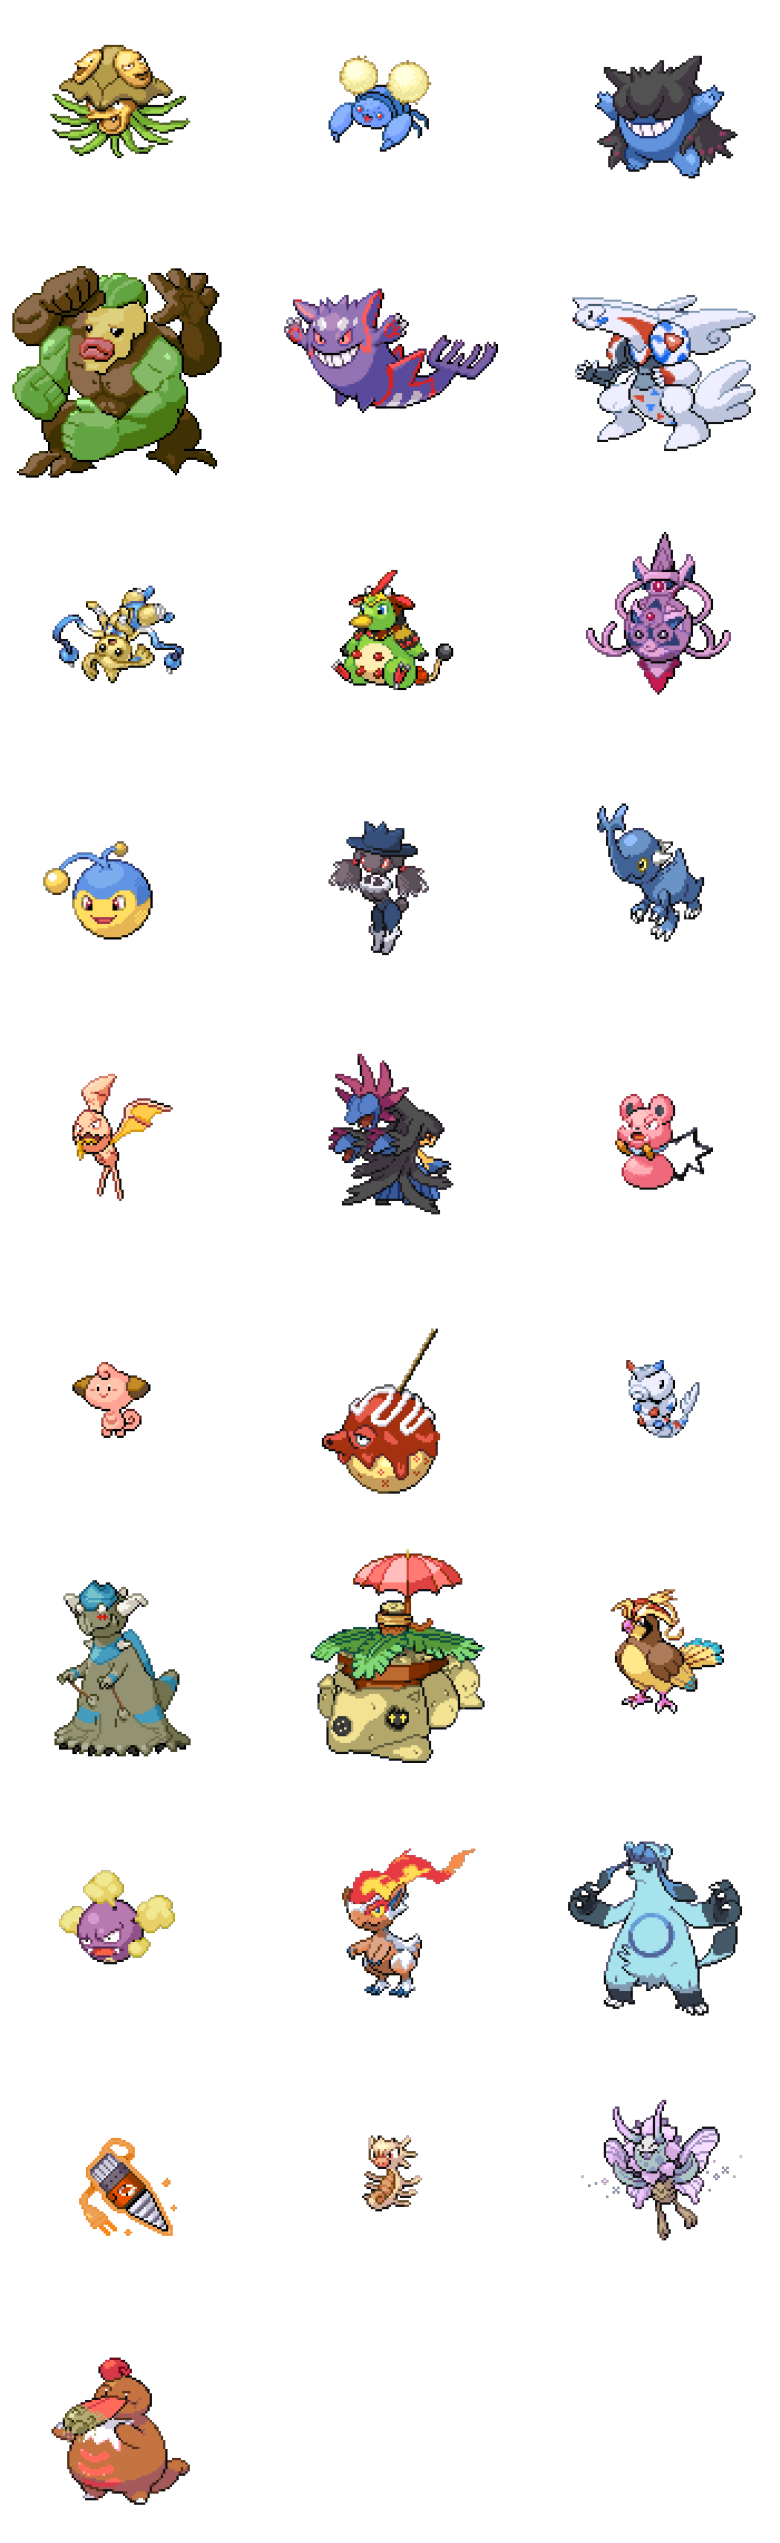

In [22]:
import random as rd
# test for all models import random as rd file
pathsFinal = [f"spritefusion/{rd.randint(1,400)}.{rd.randint(1,400)}.png" for i in range(1, 50)] 
dfFusion = pd.read_csv('fusion.csv')

selectRowsWhereFilepath = lambda x: dfFusion[dfFusion['img'] == x] 
try:
    dfFinal = pd.concat([selectRowsWhereFilepath(filepath) for filepath in pathsFinal])
except:
    print("Error: One or more filepaths not found in dataset")
    
df_type2 = dfFinal[dfFinal['Type 2'].notna()].copy() 
df_type2['Type 1'] = df_type2['Type 2'] 
try:

    dfFinal = pd.concat([dfFinal, df_type2]) 
except:
    print("Error: One or more filepaths not found in dataset")
    
dfFinal = dfFinal.drop(['Type 2'], axis=1) 
print(dfFinal)

show_images(pathsFinal)

X_final = np.array([load_and_preprocess_image(filepath) for filepath in dfFinal['img']]) 
Y_final = dfFinal['Type 1']

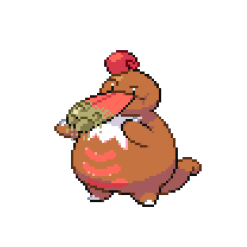

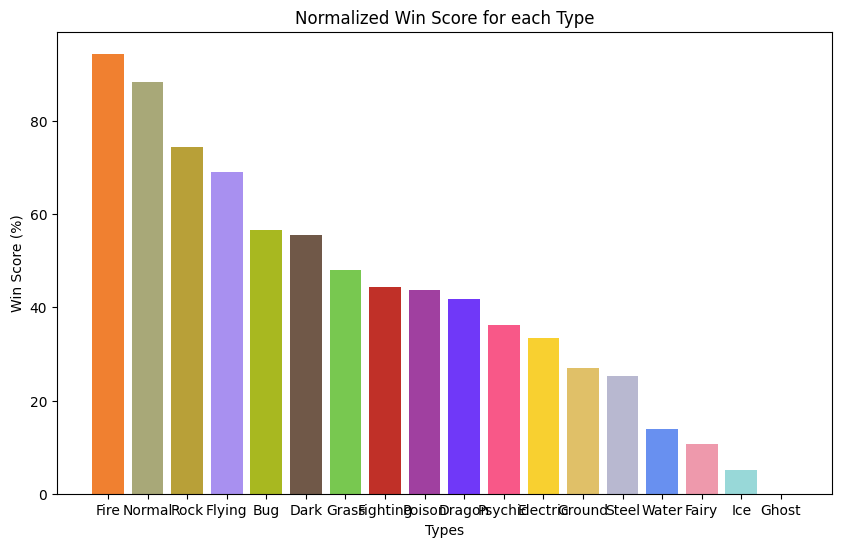

In [27]:
#Regression Logistique

k = -1

imageAtest = [X_final[k]]

#get row k for the image to test
pokemon = dfFinal.iloc[k]
imageLie = pokemon['img']
# Replace 'pokemon_name' with the name of the Pokemon you are interested in
pokemon_name = pokemon['nom']


show_images([imageLie])

AllPredictions = {typeCombo: models[typeCombo]['model'].predict_proba(imageAtest) for typeCombo in models.keys()}



# Initialize score dictionaries
win_scores = {t: 0 for t in types}
weighted_scores = {t: 0 for t in types}

# For each type combination
for typeCombo, predictions in AllPredictions.items():
    # Split the typeCombo string into individual types
    type1, type2 = typeCombo.split('_')
    
    # The first element in predictions is the probability for the first type
    # and the second element is the probability for the second type
    prob_type1, prob_type2 = predictions[0]
    
    # Compare the probabilities and increment the win score for the winning type
    if prob_type1 > prob_type2:
        win_scores[type1] += 1
        weighted_scores[type1] += prob_type1
    elif prob_type2 > prob_type1:
        win_scores[type2] += 1
        weighted_scores[type2] += prob_type2

#print(win_scores)
#print(weighted_scores)

# Get the 3 types with the highest win score
top_types = sorted(weighted_scores, key=win_scores.get, reverse=True)[:4]
#print(top_types)

#show histogram of for each type sorted by win score with colors of types :
custom_colors = {
    'Bug': '#a8b820',
    'Dark': '#705848',
    'Dragon': '#7038f8',
    'Electric': '#f8d030',
    'Fairy': '#ee99ac',
    'Fighting': '#c03028',
    'Fire': '#f08030',
    'Flying': '#a890f0', 
    'Ghost': '#705898',
    'Grass': '#78c850',
    'Ground': '#e0c068',
    'Ice': '#98d8d8',
    'Normal': '#a8a878',
    'Poison': '#a040a0',
    'Psychic': '#f85888',
    'Rock': '#b8a038',
    'Steel': '#b8b8d0',
    'Water': '#6890f0'
}

# Normalize scores
normalized_win_scores = {t: (score / len(types)) * 100 for t, score in win_scores.items()}
normalized_weighted_scores = {t: (score / len(types)) * 100 for t, score in weighted_scores.items()}

# Sort normalized scores by value in descending order
sorted_normalized_scores = dict(sorted(normalized_weighted_scores.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.bar(sorted_normalized_scores.keys(), sorted_normalized_scores.values(), color=[custom_colors[t] for t in sorted_normalized_scores.keys()])
plt.xlabel('Types')
plt.ylabel('Win Score (%)')
plt.title('Normalized Win Score for each Type')
plt.show()



Average Accuracy: 0.6553263491540755
Average F1 Score: 0.6461033839191463
Average Recall: 0.657989897337598
Lowest Accuracy: Dragon_Electric (0.375)
Lowest Recall: Bug_Ghost (0.16666666666666666)
Lowest F1 Score: Bug_Ghost (0.2)
{'Grass': 0.6787374343730336, 'Psychic': 0.6165258920477137, 'Dark': 0.6340413150695985, 'Bug': 0.6223762424912783, 'Rock': 0.5898949347950112, 'Steel': 0.6342307931601776, 'Normal': 0.6992547716809112, 'Water': 0.6811038710259032, 'Dragon': 0.7114520211027252, 'Electric': 0.6172159386173228, 'Poison': 0.610481896368542, 'Fire': 0.732440335944575, 'Fairy': 0.6771180155451254, 'Ice': 0.7395036011236039, 'Ground': 0.6054510137474803, 'Ghost': 0.6435345397838568, 'Fighting': 0.6754997210761088, 'Flying': 0.6270119468203906}
{'Grass': 0.6649384000595074, 'Psychic': 0.60518862625264, 'Dark': 0.6464543712221731, 'Bug': 0.534345306750151, 'Rock': 0.558892088303853, 'Steel': 0.507419149477973, 'Normal': 0.7336125221716664, 'Water': 0.7919430789443577, 'Dragon': 0.75390

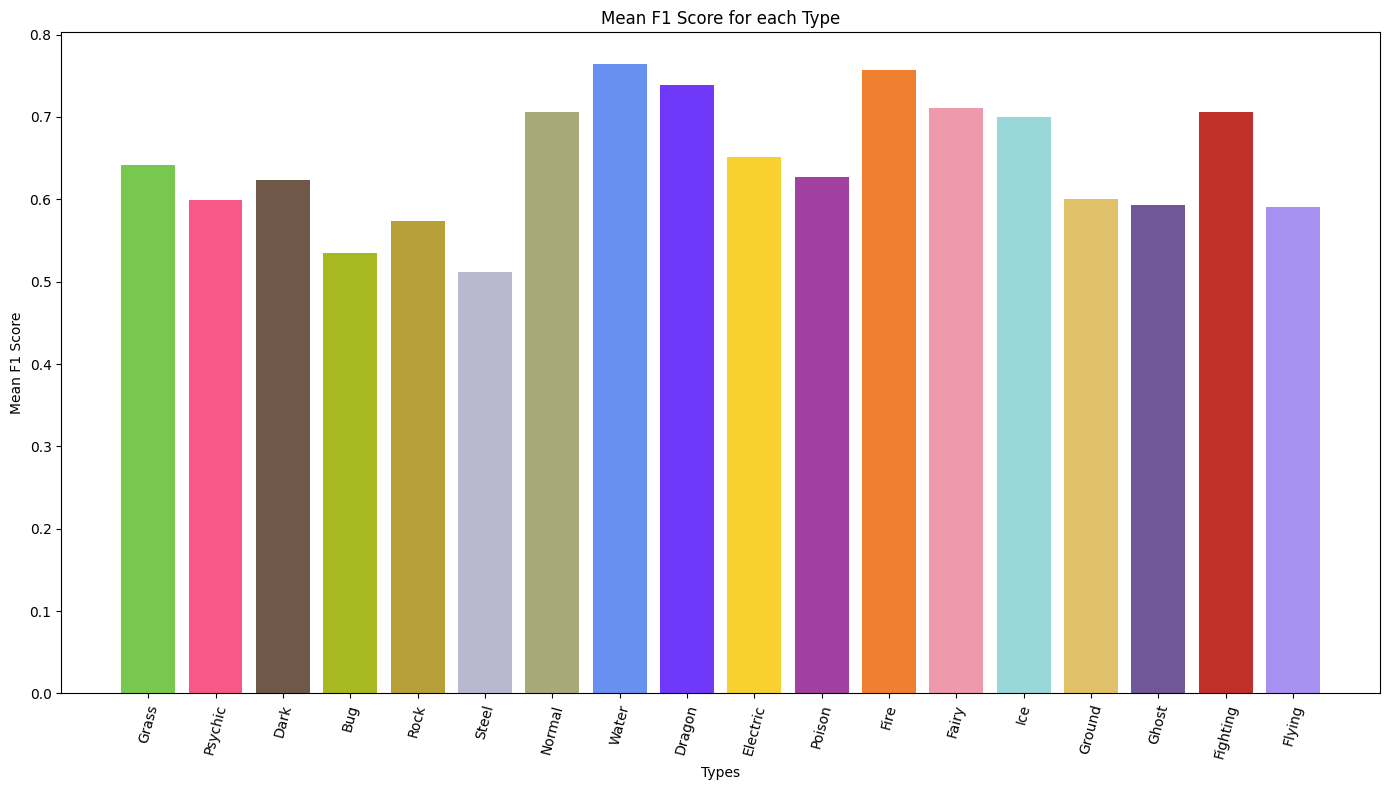

In [28]:
#Regression Logistique

AccuracyMean = np.mean([models[typeCombo]['accuracy_score'] for typeCombo in models.keys()])
F1Mean = np.mean([models[typeCombo]['f1_score'] for typeCombo in models.keys()])
RecallMean = np.mean([models[typeCombo]['Recall'] for typeCombo in models.keys()])
print(f'Average Accuracy: {AccuracyMean}')
print(f'Average F1 Score: {F1Mean}')
print(f'Average Recall: {RecallMean}')

# Trouver les performances les plus basses
lowest_accuracy = min(models, key=lambda x: models[x]['accuracy_score'])
lowest_recall = min(models, key=lambda x: models[x]['Recall'])
lowest_f1 = min(models, key=lambda x: models[x]['f1_score'])
print(f'Lowest Accuracy: {lowest_accuracy} ({models[lowest_accuracy]["accuracy_score"]})')
print(f'Lowest Recall: {lowest_recall} ({models[lowest_recall]["Recall"]})')
print(f'Lowest F1 Score: {lowest_f1} ({models[lowest_f1]["f1_score"]})')

# Calcul des moyennes pour chaque type
mean_accuracy = {type1: np.mean([models[typeCombo]['accuracy_score'] for typeCombo in models.keys() if type1 in typeCombo]) for type1 in types}
print(mean_accuracy)
mean_recall = {type1: np.mean([models[typeCombo]['Recall'] for typeCombo in models.keys() if type1 in typeCombo]) for type1 in types}
print(mean_recall)
mean_f1 = {type1: np.mean([models[typeCombo]['f1_score'] for typeCombo in models.keys() if type1 in typeCombo]) for type1 in types}
print(mean_f1)

# Histogramme des scores F1 moyens pour chaque type
plt.figure(figsize=(14, 8))  # Augmente la taille de la figure.
plt.bar(mean_f1.keys(), mean_f1.values(), color=[custom_colors[t] for t in mean_f1.keys()])
plt.xlabel('Types')
plt.ylabel('Mean F1 Score')
plt.title('Mean F1 Score for each Type')
plt.xticks(rotation=75)  # Fait pivoter les étiquettes pour qu'elles ne se chevauchent pas.
plt.tight_layout()  # Ajuste automatiquement la disposition.
plt.show()  # Affiche le graphique.


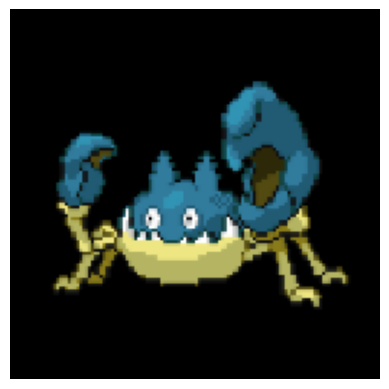

In [68]:
X_final[-1].reshape(128, 128, 3)

showtheimage = X_final[-1].reshape(128, 128, 3)
plt.imshow(showtheimage)
plt.axis('off')
plt.show()

Average Accuracy: 0.5716856358614139
Average F1 Score: 0.5687089599830902
Average Recall: 0.5713590724861055
Lowest Accuracy: Fairy_Ice (0.15384615384615385)
Lowest Recall: Grass_Ice (0.0)
Lowest F1 Score: Grass_Ice (0.0)
{'Grass': 0.5946401930602478, 'Psychic': 0.5501377495165136, 'Dark': 0.5701525748877937, 'Bug': 0.5702823885284574, 'Rock': 0.5436772023107342, 'Steel': 0.5752838581216837, 'Normal': 0.5909747870538987, 'Water': 0.6230244361591896, 'Dragon': 0.5863754196264432, 'Electric': 0.5681638762045337, 'Poison': 0.5585857608592327, 'Fire': 0.587585536400375, 'Fairy': 0.5430541503111834, 'Ice': 0.6083101817268597, 'Ground': 0.5465579725351063, 'Ghost': 0.5644028244565487, 'Fighting': 0.5605366735758265, 'Flying': 0.5485958601708207}
{'Grass': 0.5713703587838536, 'Psychic': 0.5355535756054788, 'Dark': 0.6118777335495601, 'Bug': 0.4589221428321774, 'Rock': 0.5454036159918514, 'Steel': 0.48133138103726336, 'Normal': 0.6342021289072985, 'Water': 0.716217446473201, 'Dragon': 0.652806

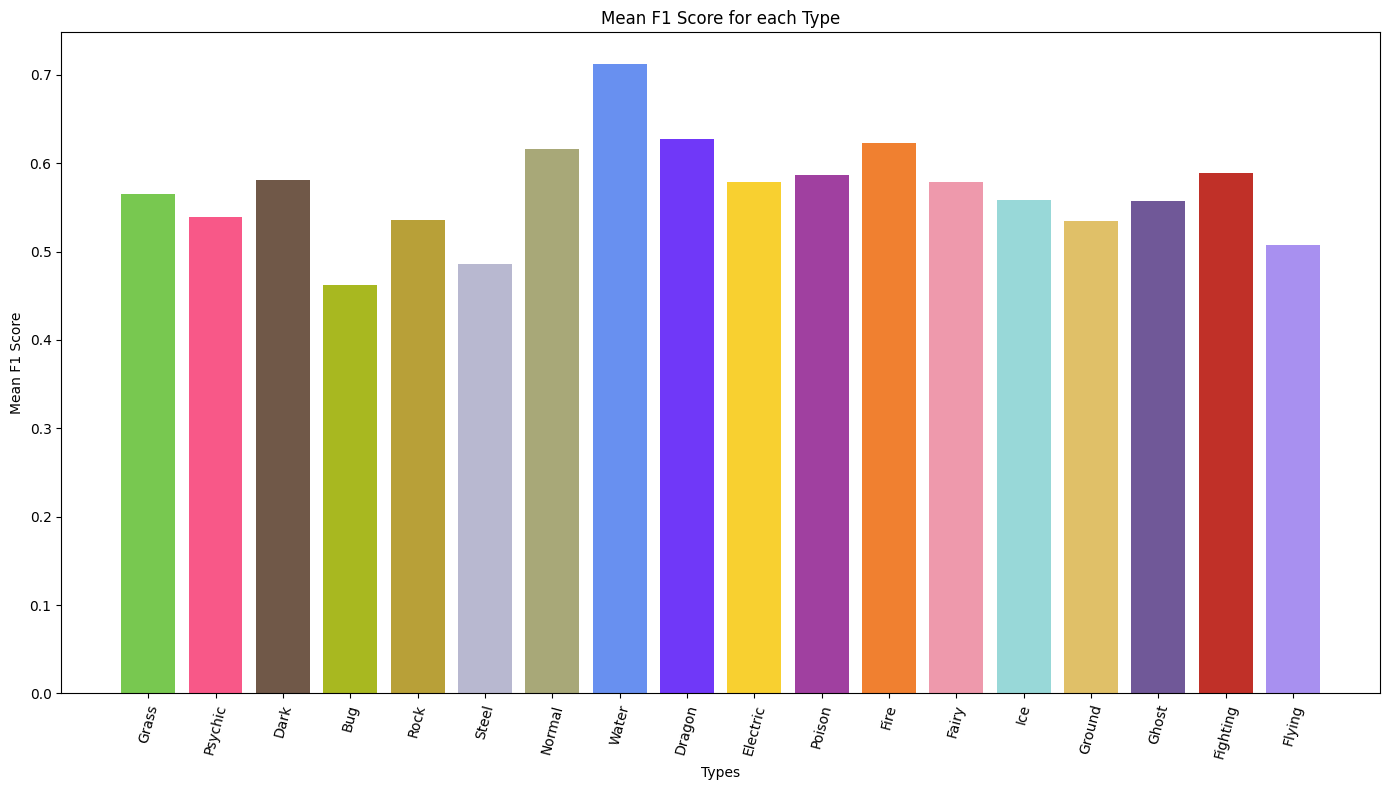

In [66]:
#Decision tree

AccuracyMean = np.mean([models[typeCombo]['accuracy_score'] for typeCombo in models.keys()])
F1Mean = np.mean([models[typeCombo]['f1_score'] for typeCombo in models.keys()])
RecallMean = np.mean([models[typeCombo]['Recall'] for typeCombo in models.keys()])
print(f'Average Accuracy: {AccuracyMean}')
print(f'Average F1 Score: {F1Mean}')
print(f'Average Recall: {RecallMean}')

# Trouver les performances les plus basses
lowest_accuracy = min(models, key=lambda x: models[x]['accuracy_score'])
lowest_recall = min(models, key=lambda x: models[x]['Recall'])
lowest_f1 = min(models, key=lambda x: models[x]['f1_score'])
print(f'Lowest Accuracy: {lowest_accuracy} ({models[lowest_accuracy]["accuracy_score"]})')
print(f'Lowest Recall: {lowest_recall} ({models[lowest_recall]["Recall"]})')
print(f'Lowest F1 Score: {lowest_f1} ({models[lowest_f1]["f1_score"]})')

# Calcul des moyennes pour chaque type
mean_accuracy = {type1: np.mean([models[typeCombo]['accuracy_score'] for typeCombo in models.keys() if type1 in typeCombo]) for type1 in types}
print(mean_accuracy)
mean_recall = {type1: np.mean([models[typeCombo]['Recall'] for typeCombo in models.keys() if type1 in typeCombo]) for type1 in types}
print(mean_recall)
mean_f1 = {type1: np.mean([models[typeCombo]['f1_score'] for typeCombo in models.keys() if type1 in typeCombo]) for type1 in types}
print(mean_f1)

# Histogramme des scores F1 moyens pour chaque type
plt.figure(figsize=(14, 8))  # Augmente la taille de la figure.
plt.bar(mean_f1.keys(), mean_f1.values(), color=[custom_colors[t] for t in mean_f1.keys()])
plt.xlabel('Types')
plt.ylabel('Mean F1 Score')
plt.title('Mean F1 Score for each Type')
plt.xticks(rotation=75)  # Fait pivoter les étiquettes pour qu'elles ne se chevauchent pas.
plt.tight_layout()  # Ajuste automatiquement la disposition.
plt.show()  # Affiche le graphique.


Average Accuracy: 0.5716856358614139
Average F1 Score: 0.5687089599830902
Average Recall: 0.5713590724861055
Lowest Accuracy: Fairy_Ice (0.15384615384615385)
Lowest Recall: Grass_Ice (0.0)
Lowest F1 Score: Grass_Ice (0.0)
{'Grass': 0.5946401930602478, 'Psychic': 0.5501377495165136, 'Dark': 0.5701525748877937, 'Bug': 0.5702823885284574, 'Rock': 0.5436772023107342, 'Steel': 0.5752838581216837, 'Normal': 0.5909747870538987, 'Water': 0.6230244361591896, 'Dragon': 0.5863754196264432, 'Electric': 0.5681638762045337, 'Poison': 0.5585857608592327, 'Fire': 0.587585536400375, 'Fairy': 0.5430541503111834, 'Ice': 0.6083101817268597, 'Ground': 0.5465579725351063, 'Ghost': 0.5644028244565487, 'Fighting': 0.5605366735758265, 'Flying': 0.5485958601708207}
{'Grass': 0.5713703587838536, 'Psychic': 0.5355535756054788, 'Dark': 0.6118777335495601, 'Bug': 0.4589221428321774, 'Rock': 0.5454036159918514, 'Steel': 0.48133138103726336, 'Normal': 0.6342021289072985, 'Water': 0.716217446473201, 'Dragon': 0.652806

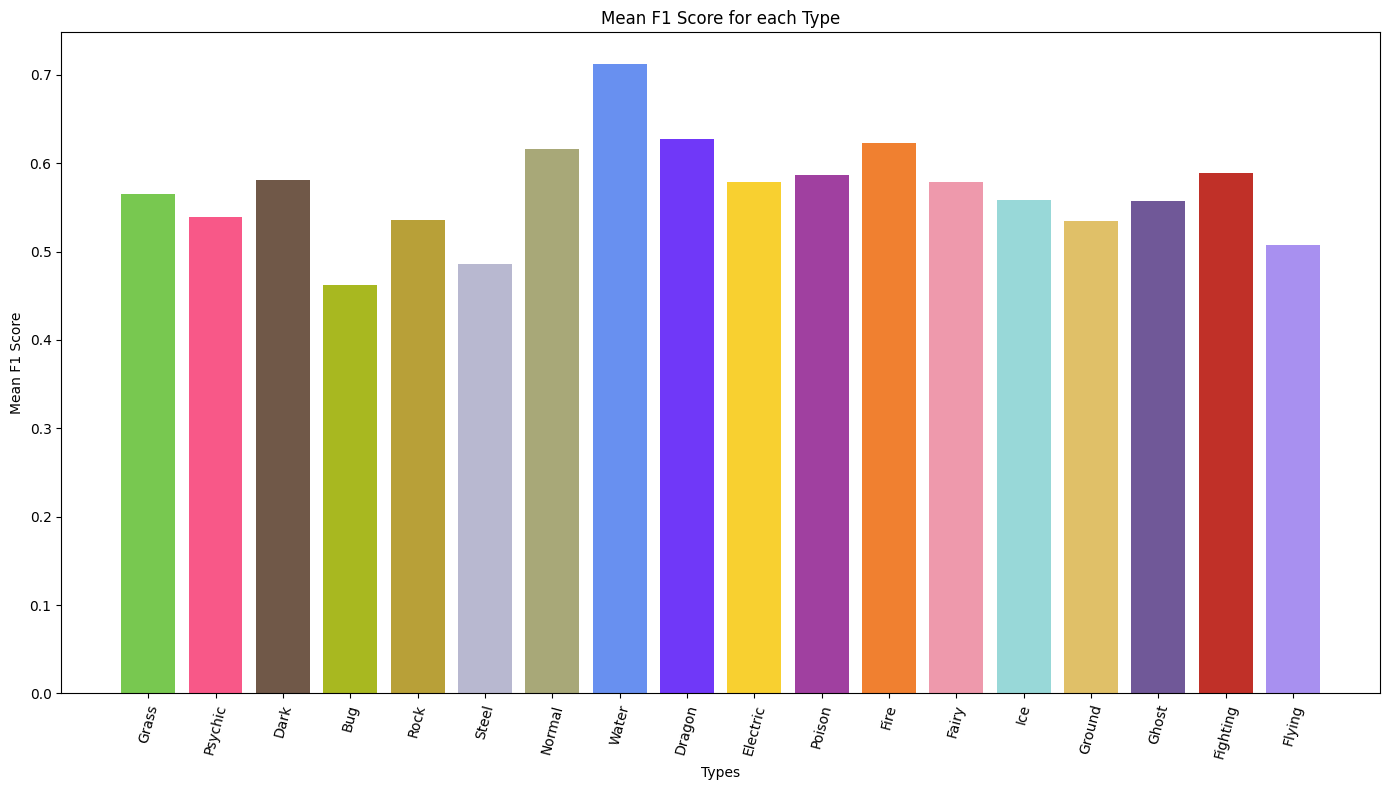

In [68]:
#Decision Tree

AccuracyMean = np.mean([models[typeCombo]['accuracy_score'] for typeCombo in models.keys()])
F1Mean = np.mean([models[typeCombo]['f1_score'] for typeCombo in models.keys()])
RecallMean = np.mean([models[typeCombo]['Recall'] for typeCombo in models.keys()])
print(f'Average Accuracy: {AccuracyMean}')
print(f'Average F1 Score: {F1Mean}')
print(f'Average Recall: {RecallMean}')

# Trouver les performances les plus basses
lowest_accuracy = min(models, key=lambda x: models[x]['accuracy_score'])
lowest_recall = min(models, key=lambda x: models[x]['Recall'])
lowest_f1 = min(models, key=lambda x: models[x]['f1_score'])
print(f'Lowest Accuracy: {lowest_accuracy} ({models[lowest_accuracy]["accuracy_score"]})')
print(f'Lowest Recall: {lowest_recall} ({models[lowest_recall]["Recall"]})')
print(f'Lowest F1 Score: {lowest_f1} ({models[lowest_f1]["f1_score"]})')

# Calcul des moyennes pour chaque type
mean_accuracy = {type1: np.mean([models[typeCombo]['accuracy_score'] for typeCombo in models.keys() if type1 in typeCombo]) for type1 in types}
print(mean_accuracy)
mean_recall = {type1: np.mean([models[typeCombo]['Recall'] for typeCombo in models.keys() if type1 in typeCombo]) for type1 in types}
print(mean_recall)
mean_f1 = {type1: np.mean([models[typeCombo]['f1_score'] for typeCombo in models.keys() if type1 in typeCombo]) for type1 in types}
print(mean_f1)

# Histogramme des scores F1 moyens pour chaque type
plt.figure(figsize=(14, 8))  # Augmente la taille de la figure.
plt.bar(mean_f1.keys(), mean_f1.values(), color=[custom_colors[t] for t in mean_f1.keys()])
plt.xlabel('Types')
plt.ylabel('Mean F1 Score')
plt.title('Mean F1 Score for each Type')
plt.xticks(rotation=75)  # Fait pivoter les étiquettes pour qu'elles ne se chevauchent pas.
plt.tight_layout()  # Ajuste automatiquement la disposition.
plt.show()  # Affiche le graphique.


Average Accuracy: 0.6688152074032706
Average F1 Score: 0.6640387490236446
Average Recall: 0.7070742733630644
Lowest Accuracy: Dragon_Electric (0.375)
Lowest Recall: Flying_Poison (0.06666666666666667)
Lowest F1 Score: Flying_Poison (0.10526315789473684)
{'Grass': 0.6674191500269379, 'Psychic': 0.6704604800281726, 'Dark': 0.6561891446316751, 'Bug': 0.6361719186265896, 'Rock': 0.6088622627055778, 'Steel': 0.6716656193402233, 'Normal': 0.7022202154502142, 'Water': 0.6967460163606357, 'Dragon': 0.6912274202267212, 'Electric': 0.6485740240152006, 'Poison': 0.6243344594650881, 'Fire': 0.7400509652773956, 'Fairy': 0.6698799921306315, 'Ice': 0.7443598791391226, 'Ground': 0.6471847092507237, 'Ghost': 0.6459638710103106, 'Fighting': 0.6927705321900072, 'Flying': 0.624593073383645}
{'Grass': 0.6706537967351116, 'Psychic': 0.7228143396395991, 'Dark': 0.7368199911543565, 'Bug': 0.5730304777882633, 'Rock': 0.575874125874126, 'Steel': 0.5487097869450811, 'Normal': 0.7748609701593041, 'Water': 0.89515

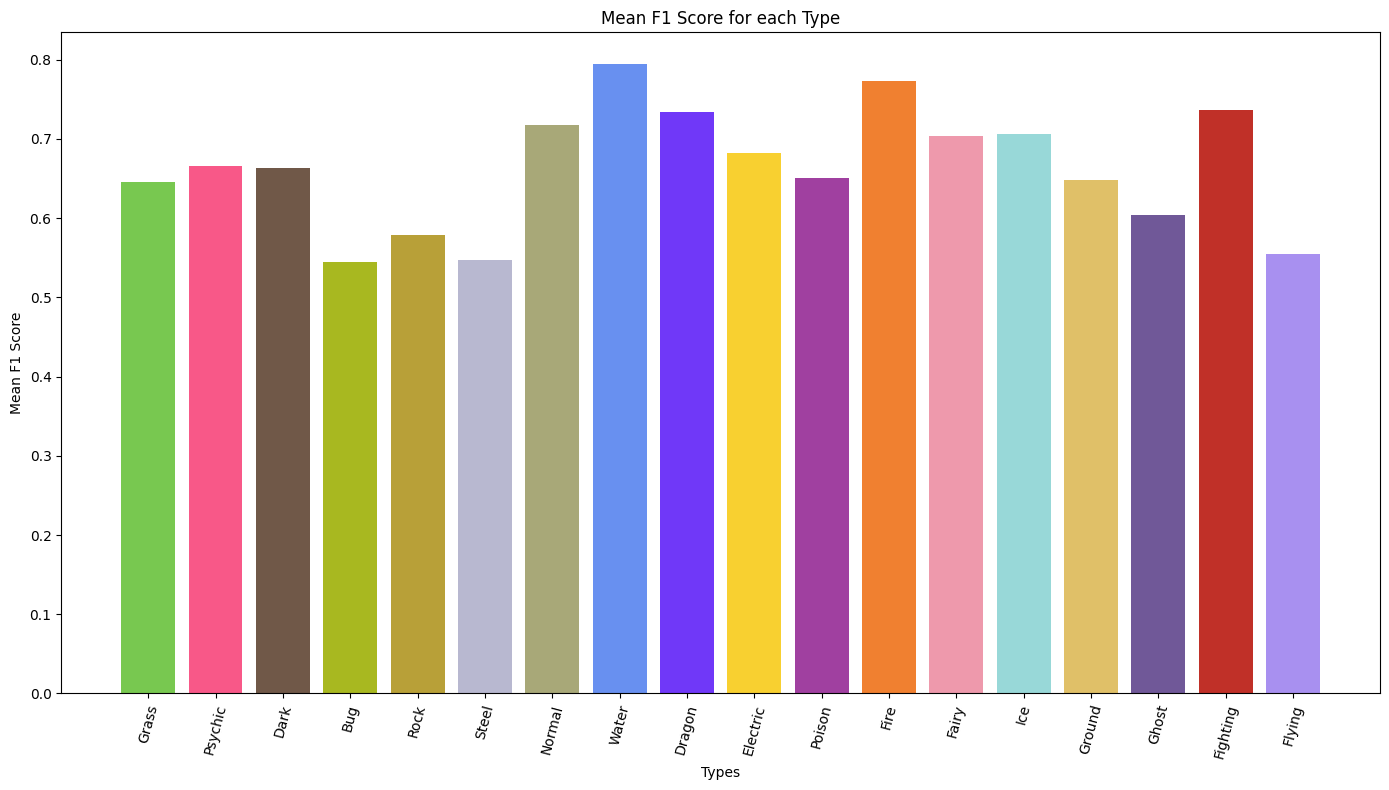

In [64]:
#Random Forest

AccuracyMean = np.mean([models[typeCombo]['accuracy_score'] for typeCombo in models.keys()])
F1Mean = np.mean([models[typeCombo]['f1_score'] for typeCombo in models.keys()])
RecallMean = np.mean([models[typeCombo]['Recall'] for typeCombo in models.keys()])
print(f'Average Accuracy: {AccuracyMean}')
print(f'Average F1 Score: {F1Mean}')
print(f'Average Recall: {RecallMean}')

# Trouver les performances les plus basses
lowest_accuracy = min(models, key=lambda x: models[x]['accuracy_score'])
lowest_recall = min(models, key=lambda x: models[x]['Recall'])
lowest_f1 = min(models, key=lambda x: models[x]['f1_score'])
print(f'Lowest Accuracy: {lowest_accuracy} ({models[lowest_accuracy]["accuracy_score"]})')
print(f'Lowest Recall: {lowest_recall} ({models[lowest_recall]["Recall"]})')
print(f'Lowest F1 Score: {lowest_f1} ({models[lowest_f1]["f1_score"]})')

# Calcul des moyennes pour chaque type
mean_accuracy = {type1: np.mean([models[typeCombo]['accuracy_score'] for typeCombo in models.keys() if type1 in typeCombo]) for type1 in types}
print(mean_accuracy)
mean_recall = {type1: np.mean([models[typeCombo]['Recall'] for typeCombo in models.keys() if type1 in typeCombo]) for type1 in types}
print(mean_recall)
mean_f1 = {type1: np.mean([models[typeCombo]['f1_score'] for typeCombo in models.keys() if type1 in typeCombo]) for type1 in types}
print(mean_f1)

# Histogramme des scores F1 moyens pour chaque type
plt.figure(figsize=(14, 8))  # Augmente la taille de la figure.
plt.bar(mean_f1.keys(), mean_f1.values(), color=[custom_colors[t] for t in mean_f1.keys()])
plt.xlabel('Types')
plt.ylabel('Mean F1 Score')
plt.title('Mean F1 Score for each Type')
plt.xticks(rotation=75)  # Fait pivoter les étiquettes pour qu'elles ne se chevauchent pas.
plt.tight_layout()  # Ajuste automatiquement la disposition.
plt.show()  # Affiche le graphique.


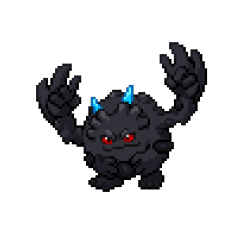

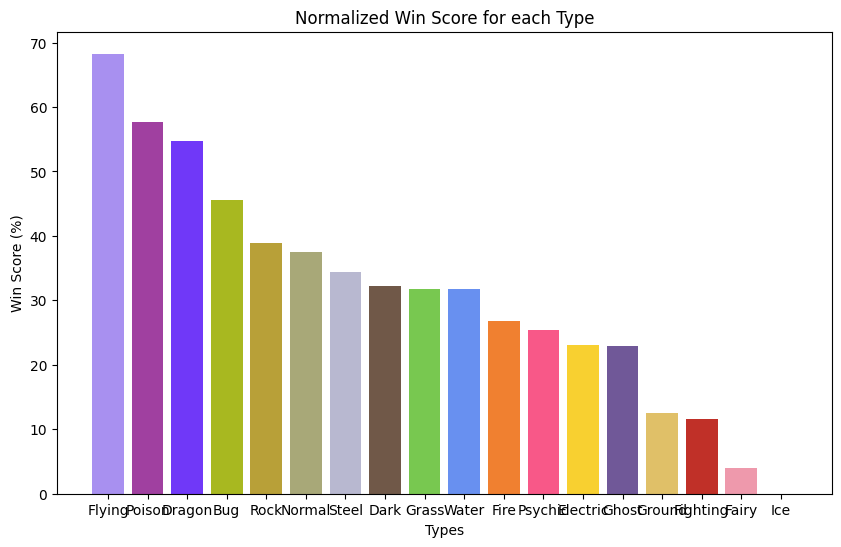

In [53]:
#Random Forest

k = -1

imageAtest = [X_final[k]]

#get row k for the image to test
pokemon = dfFinal.iloc[k]
imageLie = pokemon['img']
# Replace 'pokemon_name' with the name of the Pokemon you are interested in
pokemon_name = pokemon['nom']


show_images([imageLie])

AllPredictions = {typeCombo: models[typeCombo]['model'].predict_proba(imageAtest) for typeCombo in models.keys()}



# Initialize score dictionaries
win_scores = {t: 0 for t in types}
weighted_scores = {t: 0 for t in types}

# For each type combination
for typeCombo, predictions in AllPredictions.items():
    # Split the typeCombo string into individual types
    type1, type2 = typeCombo.split('_')
    
    # The first element in predictions is the probability for the first type
    # and the second element is the probability for the second type
    prob_type1, prob_type2 = predictions[0]
    
    # Compare the probabilities and increment the win score for the winning type
    if prob_type1 > prob_type2:
        win_scores[type1] += 1
        weighted_scores[type1] += prob_type1
    elif prob_type2 > prob_type1:
        win_scores[type2] += 1
        weighted_scores[type2] += prob_type2

#print(win_scores)
#print(weighted_scores)

# Get the 3 types with the highest win score
top_types = sorted(weighted_scores, key=win_scores.get, reverse=True)[:4]
#print(top_types)

#show histogram of for each type sorted by win score with colors of types :
custom_colors = {
    'Bug': '#a8b820',
    'Dark': '#705848',
    'Dragon': '#7038f8',
    'Electric': '#f8d030',
    'Fairy': '#ee99ac',
    'Fighting': '#c03028',
    'Fire': '#f08030',
    'Flying': '#a890f0', 
    'Ghost': '#705898',
    'Grass': '#78c850',
    'Ground': '#e0c068',
    'Ice': '#98d8d8',
    'Normal': '#a8a878',
    'Poison': '#a040a0',
    'Psychic': '#f85888',
    'Rock': '#b8a038',
    'Steel': '#b8b8d0',
    'Water': '#6890f0'
}

# Normalize scores
normalized_win_scores = {t: (score / len(types)) * 100 for t, score in win_scores.items()}
normalized_weighted_scores = {t: (score / len(types)) * 100 for t, score in weighted_scores.items()}

# Sort normalized scores by value in descending order
sorted_normalized_scores = dict(sorted(normalized_weighted_scores.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.bar(sorted_normalized_scores.keys(), sorted_normalized_scores.values(), color=[custom_colors[t] for t in sorted_normalized_scores.keys()])
plt.xlabel('Types')
plt.ylabel('Win Score (%)')
plt.title('Normalized Win Score for each Type')
plt.show()



In [24]:
#KNN

AccuracyMean = np.mean([models[typeCombo]['accuracy_score'] for typeCombo in models.keys()])
F1Mean = np.mean([models[typeCombo]['f1_score'] for typeCombo in models.keys()])
RecallMean = np.mean([models[typeCombo]['Recall'] for typeCombo in models.keys()])
print(f'Average Accuracy: {AccuracyMean}')
print(f'Average F1 Score: {F1Mean}')
print(f'Average Recall: {RecallMean}')

# Trouver les performances les plus basses
lowest_accuracy = min(models, key=lambda x: models[x]['accuracy_score'])
lowest_recall = min(models, key=lambda x: models[x]['Recall'])
lowest_f1 = min(models, key=lambda x: models[x]['f1_score'])
print(f'Lowest Accuracy: {lowest_accuracy} ({models[lowest_accuracy]["accuracy_score"]})')
print(f'Lowest Recall: {lowest_recall} ({models[lowest_recall]["Recall"]})')
print(f'Lowest F1 Score: {lowest_f1} ({models[lowest_f1]["f1_score"]})')

# Calcul des moyennes pour chaque type
mean_accuracy = {type1: np.mean([models[typeCombo]['accuracy_score'] for typeCombo in models.keys() if type1 in typeCombo]) for type1 in types}
print(mean_accuracy)
mean_recall = {type1: np.mean([models[typeCombo]['Recall'] for typeCombo in models.keys() if type1 in typeCombo]) for type1 in types}
print(mean_recall)
mean_f1 = {type1: np.mean([models[typeCombo]['f1_score'] for typeCombo in models.keys() if type1 in typeCombo]) for type1 in types}
print(mean_f1)

# Histogramme des scores F1 moyens pour chaque type
plt.figure(figsize=(14, 8))  # Augmente la taille de la figure.
plt.bar(mean_f1.keys(), mean_f1.values(), color=[custom_colors[t] for t in mean_f1.keys()])
plt.xlabel('Types')
plt.ylabel('Mean F1 Score')
plt.title('Mean F1 Score for each Type')
plt.xticks(rotation=75)  # Fait pivoter les étiquettes pour qu'elles ne se chevauchent pas.
plt.tight_layout()  # Ajuste automatiquement la disposition.
plt.show()  # Affiche le graphique.


Average Accuracy: 0.6382312400314308
Average F1 Score: 0.5963254578457932
Average Recall: 0.6116072971952289
Lowest Accuracy: Ground_Water (0.2857142857142857)
Lowest Recall: Flying_Ghost (0.0)
Lowest F1 Score: Flying_Ghost (0.0)
{'Grass': 0.6531441140552069, 'Psychic': 0.6498030763825665, 'Dark': 0.641557879084959, 'Bug': 0.6251662722986381, 'Rock': 0.6199067694016085, 'Steel': 0.6072106465625406, 'Normal': 0.6677835941165009, 'Water': 0.6207091237435625, 'Dragon': 0.6652213286748391, 'Electric': 0.6091882007842215, 'Poison': 0.6322660303629032, 'Fire': 0.700251506083575, 'Fairy': 0.6580117665795415, 'Ice': 0.6933093541940627, 'Ground': 0.5934834314840067, 'Ghost': 0.6083497959576998, 'Fighting': 0.600425556841233, 'Flying': 0.6423738739580899}
{'Grass': 0.611894079584391, 'Psychic': 0.6159807752800832, 'Dark': 0.5109943977591036, 'Bug': 0.4514710875437519, 'Rock': 0.573993653405418, 'Steel': 0.4260508445802563, 'Normal': 0.6773162756538715, 'Water': 0.6848994306347248, 'Dragon': 0.62

NameError: name 'custom_colors' is not defined

<Figure size 1400x800 with 0 Axes>

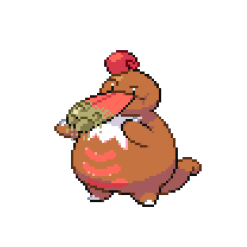

KeyboardInterrupt: 

In [23]:
#KNN

k = -1

imageAtest = [X_final[k]]

#get row k for the image to test
pokemon = dfFinal.iloc[k]
imageLie = pokemon['img']
# Replace 'pokemon_name' with the name of the Pokemon you are interested in
pokemon_name = pokemon['nom']


show_images([imageLie])

AllPredictions = {typeCombo: models[typeCombo]['model'].predict_proba(imageAtest) for typeCombo in models.keys()}



# Initialize score dictionaries
win_scores = {t: 0 for t in types}
weighted_scores = {t: 0 for t in types}

# For each type combination
for typeCombo, predictions in AllPredictions.items():
    # Split the typeCombo string into individual types
    type1, type2 = typeCombo.split('_')
    
    # The first element in predictions is the probability for the first type
    # and the second element is the probability for the second type
    prob_type1, prob_type2 = predictions[0]
    
    # Compare the probabilities and increment the win score for the winning type
    if prob_type1 > prob_type2:
        win_scores[type1] += 1
        weighted_scores[type1] += prob_type1
    elif prob_type2 > prob_type1:
        win_scores[type2] += 1
        weighted_scores[type2] += prob_type2

#print(win_scores)
#print(weighted_scores)

# Get the 3 types with the highest win score
top_types = sorted(weighted_scores, key=win_scores.get, reverse=True)[:4]
#print(top_types)

#show histogram of for each type sorted by win score with colors of types :
custom_colors = {
    'Bug': '#a8b820',
    'Dark': '#705848',
    'Dragon': '#7038f8',
    'Electric': '#f8d030',
    'Fairy': '#ee99ac',
    'Fighting': '#c03028',
    'Fire': '#f08030',
    'Flying': '#a890f0', 
    'Ghost': '#705898',
    'Grass': '#78c850',
    'Ground': '#e0c068',
    'Ice': '#98d8d8',
    'Normal': '#a8a878',
    'Poison': '#a040a0',
    'Psychic': '#f85888',
    'Rock': '#b8a038',
    'Steel': '#b8b8d0',
    'Water': '#6890f0'
}

# Normalize scores
normalized_win_scores = {t: (score / len(types)) * 100 for t, score in win_scores.items()}
normalized_weighted_scores = {t: (score / len(types)) * 100 for t, score in weighted_scores.items()}

# Sort normalized scores by value in descending order
sorted_normalized_scores = dict(sorted(normalized_weighted_scores.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 6))
plt.bar(sorted_normalized_scores.keys(), sorted_normalized_scores.values(), color=[custom_colors[t] for t in sorted_normalized_scores.keys()])
plt.xlabel('Types')
plt.ylabel('Win Score (%)')
plt.title('Normalized Win Score for each Type')
plt.show()

